#Систем за препорака на книги

In [ ]:
debug = True



Во наредните делови ќе разгледуваме креирање на систем за препорака на книги, каде ќе ги опфатиме сите клучни чекори за неговото создавање.

Податоците се превземени од Kaggle
https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews/data?select=books_data.csv, а искористен е само еден дел од ова масивно податочно множество.

Податоците ги имаме визуелизирано за читателот да има појасна слика за каков тип на податоци станува збор, како и за помош при прочистувањето на податоците и нивно намалување.
Во истиот овој дел правиме анализа на сентиментот за да имаме појасна слика за податоците.

Понатаму, ги екстрахираме сите битни својства од податоците, како што се жанрот на книгите, автор и издавач.
Користејќи ги името и описот на книгите, го употребуавме RoBERTa моделот за додавање на векторска претстава за истите.

Со тоа, следен чекор е создавањето на графот користејќи Pytorch Geometric. Со тоа создаваме компјутерска претстава на нашиот граф на знаење врз кој понатаму ќе ги тренираме и тестираме моделите - GraphSAGE, GAТ и Transformers. После долг период тренирање - ги тестираме и правиме споредба на сите модели користејќи ја hit метриката. Од нашите резултати добиваме високо ниво на прецизност и добар знак дека овој проблем би можел да биде (и веќе е) корисен и користен во вистинскиот живот на огромен број на податоци од различни сфери.


# Loading libraries

In [ ]:
!pip install transformers
!pip install vaderSentiment
!pip install kaggle
!pip install wordcloud
!pip install torch==2.4.0  torchvision==0.19.0 torchaudio==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.0/126.0 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 797.2/797.2 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 54.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 56.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 88.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 71.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 52.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.

In [ ]:
import torch
from torch import tensor
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install pyg-lib -f https://data.pyg.org/whl/nightly/torch-${TORCH}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

2.4.0+cu121
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 29.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 16.5 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/nightly/torch-2.4.0+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 16.9 MB/s eta 0:00:00
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-atbo7s1z
  Running command git clone --filter=blob:none --quiet https://github.com/pyg-team/pytorch_geometric.git /tmp/pip-req-build-atbo7s1z
  Resolved https://github.com/pyg-team/pytorch_geometric.git to commit 0fa52cb408b6ad3627e200ba6161ca5c8571740b
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for torch-geometric: filename=torch_geometric-2.7.0-py3-

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from os.path import exists

from tqdm import tqdm

from sklearn.preprocessing import LabelEncoder

from transformers import RobertaTokenizer, RobertaModel

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from torch_geometric.data import HeteroData
from torch_geometric.loader import LinkNeighborLoader
import torch_geometric.transforms as T

%matplotlib inline

#Loading dataset

In [ ]:
!gdown 1P5czAPpwVkIoQVbvhi4yg7mj2V11W8jU

Downloading...
From: https://drive.google.com/uc?id=1P5czAPpwVkIoQVbvhi4yg7mj2V11W8jU
To: /content/kaggle.json
100% 65.0/65.0 [00:00<00:00, 280kB/s]


In [ ]:
!mkdir ~/.kaggle

In [ ]:
!cp kaggle.json ~/.kaggle/

In [ ]:
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
 99% 1.06G/1.06G [00:12<00:00, 66.0MB/s]
100% 1.06G/1.06G [00:12<00:00, 93.4MB/s]


In [ ]:
import zipfile

with zipfile.ZipFile('amazon-books-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('dataset-folder')

In [ ]:
original_ratings = pd.read_csv("dataset-folder/Books_rating.csv")

In [ ]:
original_books = pd.read_csv("dataset-folder/books_data.csv")

#Data preprocessing

## Merging ratings and books datasets

Сите рецензии ги поставуваме во books променливата, така што заедно со податокот за рецензијата ги имаме и сите податоци за книгата за која што станува збор.

In [ ]:
books = pd.merge(original_ratings, original_books, on='Title')

In [ ]:
books['Title'].nunique()

212403

In [ ]:
books.head()

Id                           Title  Price         User_id  \
0  1882931173  Its Only Art If Its Well Hung!    NaN   AVCGYZL8FQQTD   
1  0826414346        Dr. Seuss: American Icon    NaN  A30TK6U7DNS82R   
2  0826414346        Dr. Seuss: American Icon    NaN  A3UH4UZ4RSVO82   
3  0826414346        Dr. Seuss: American Icon    NaN  A2MVUWT453QH61   
4  0826414346        Dr. Seuss: American Icon    NaN  A22X4XUPKF66MR   

                          profileName review/helpfulness  review/score  \
0               Jim of Oz "jim-of-oz"                7/7           4.0   
1                       Kevin Killian              10/10           5.0   
2                        John Granger              10/11           5.0   
3  Roy E. Perry "amateur philosopher"                7/7           4.0   
4     D. H. Richards "ninthwavestore"                3/3           4.0   

   review/time                                   review/summary  \
0    940636800           Nice collection of Julie Strain images   
1   1095724800                                Really Enjoyed It   
2   1078790400  Essential for every personal and Public Library   
3   1090713600  Phlip Nel gives silly Seuss a serious treatment   
4   1107993600                           Good academic overview   

                                         review/text  \
0  This is only for Julie Strain fans. It's a col...   
1  I don't care much for Dr. Seuss but after read...   
2  If people become the books they read and if "t...   
3  Theodore Seuss Geisel (1904-1991), aka &quot;D...   
4  Philip Nel - Dr. Seuss: American IconThis is b...   

                                         description           authors  \
0                                                NaN  ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
2  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
3  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   
4  Philip Nel takes a fascinating look into the k...    ['Philip Nel']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?id=IjvHQ...   
2  http://books.google.com/books/content?id=IjvHQ...   
3  http://books.google.com/books/content?id=IjvHQ...   
4  http://books.google.com/books/content?id=IjvHQ...   

                                         previewLink  publisher publishedDate  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...        NaN          1996   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   
2  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   
3  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   
4  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   

                                            infoLink  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   
2  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   
3  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   
4  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   

                      categories  ratingsCount  
0    ['Comics & Graphic Novels']           NaN  
1  ['Biography & Autobiography']           NaN  
2  ['Biography & Autobiography']           NaN  
3  ['Biography & Autobiography']           NaN  
4  ['Biography & Autobiography']           NaN

## Handling missing values

Во податоците имаме многу редови каде книгата нема наслов, или пак идентификацискиот string не постои. Тие редови ги отфрламе.

In [ ]:
books.isnull().sum()

Id                          0
Title                     208
Price                 2518829
User_id                561787
profileName            561905
review/helpfulness          0
review/score                0
review/time                 0
review/summary            407
review/text                 8
description            640225
authors                390634
image                  540306
previewLink            330623
publisher              782617
publishedDate          354581
infoLink               330623
categories             551498
ratingsCount          1360694
dtype: int64

In [ ]:
books = books.dropna(subset=["Title", "User_id"])

In [ ]:
books = books.drop(["Price", "ratingsCount", "previewLink", "infoLink", "profileName" ,"review/helpfulness"], axis=1)

##Dataset I: All books


### Filtering dataset to reduce dimensionality

In [ ]:
books.drop_duplicates(inplace = True)

In [ ]:
books["Title"].nunique()

206711

In [ ]:
#Филтрирање на корисници што имаат повеќе од 10 рецензии

user_review_counts = books.groupby('User_id').size()
users_more_than_10 = user_review_counts[user_review_counts > 10].index.tolist()
books_filtered = books[books["User_id"].isin(users_more_than_10)]

In [ ]:
#Филтрирање на книги што имаат повеќе од 7 рецензии
books_filtered = books_filtered.groupby('Title').filter(lambda x: len(x) > 7)

In [ ]:
#Филтрирање на книги што имаат само еден автор
books_filtered['num_authors'] = books_filtered['authors'].astype(str).apply(lambda x: len(x.split(',')))
books_filtered = books_filtered[books_filtered['num_authors'] <= 1].drop(columns=['num_authors'])

In [ ]:
#Филтрирање на книги што имаат само една категорија
books_filtered['num_categories'] = books_filtered['categories'].astype(str).apply(lambda x: len(x.split(',')))
books_filtered = books_filtered[books_filtered['num_categories'] <= 1].drop(columns=['num_categories'])

In [ ]:
books_filtered['authors'] = books_filtered['authors'].str.strip("[]'")
books_filtered['categories'] = books_filtered['categories'].str.strip("[]'")

In [ ]:
books_filtered["Title"].nunique()

15651

In [ ]:
books_filtered[books_filtered["review/score"] >= 3]["Title"].nunique()

11585

In [ ]:
books_filtered[books_filtered["review/score"] >= 3]["User_id"].nunique()

24675

In [ ]:
#Број на рецензии со оценка 3 или повеќе (врски)
len(books_filtered[books_filtered["review/score"] >= 3])

496857

In [ ]:
books_filtered.head()

Id             Title         User_id  review/score  review/time  \
3  B000N7612G  The Food Of Love  A2V6FC7GVZ6T7M           5.0   1285459200   
4  B000N7612G  The Food Of Love  A1ZMXRS5770YKG           4.0   1269648000   
5  B000N7612G  The Food Of Love  A2XY7UO3HTBFLF           5.0   1151712000   
6  B000N7612G  The Food Of Love   AKPQSBU4BZNZY           4.0   1111622400   
7  B000N7612G  The Food Of Love  A1HS3BUBNZJJD6           5.0   1096848000   

                     review/summary  \
3                  The Food of Love   
4                  A Taste of Italy   
5                  simply delicious   
6                        Cameriere!   
7  Delicioso; virtuoso; bellissimo!   

                                         review/text  \
3  A tale of tangled relationships and excellent ...   
4  Longing for vicarious travel? Imagining your c...   
5  This is a very sensual book, bringing to life ...   
6  I enjoyed this book-- it was much better than ...   
7  Food, especially Italian food, and love. Just ...   

                                         description          authors  \
3  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
4  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
5  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
6  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
7  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   

                                               image publisher publishedDate  \
3  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
4  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
5  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
6  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
7  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   

  categories  
3    Fiction  
4    Fiction  
5    Fiction  
6    Fiction  
7    Fiction

In [ ]:
#Број на рецензии групирано според корисник
books_filtered.value_counts("User_id")

User_id
A1D2C0WDCSHUWZ    2676
AFVQZQ8PW0L       1550
A1X8VZWTOG8IS6    1066
A20EEWWSFMZ1PN    1063
A1K1JW1C5CUSUZ     879
                  ... 
A1WZQJW5SILMKS       1
A2P0KP3V663U6P       1
A1X0B710LUIBAG       1
A3E7CFZRYCCLJJ       1
A2I59BHRSAO3CW       1
Name: count, Length: 35043, dtype: int64

In [ ]:
books_filtered.isnull().sum()

Id                     0
Title                  0
User_id                0
review/score           0
review/time            0
review/summary       103
review/text            0
description       119658
authors            71045
image              93333
publisher         138111
publishedDate      73165
categories        127155
dtype: int64

In [ ]:
books_filtered.shape

(554467, 13)

Во unique books променливата ги ставаме сите книги кои што го исполнуваат условот да имаат повеќе од 7 рецензии

In [ ]:
unique_books_all = books_filtered.drop_duplicates(subset=['Title'])

In [ ]:
unique_books_all.head()

Id                                              Title  \
3   B000N7612G                                   The Food Of Love   
16  050552421X                   The Scarletti Curse (Candleglow)   
35  B000MCKQRS  Cruel and Unusual (G K Hall Large Print Book S...   
68  0375422811                                    The Rabbi's Cat   
77  B000O3QCH8                                From Potter's Field   

           User_id  review/score  review/time  \
3   A2V6FC7GVZ6T7M           5.0   1285459200   
16   AHN0MGJYQHQBJ           5.0    985046400   
35  A2HO898G5N5X05           5.0   1285200000   
68  A3F7XLGCTTUMWP           4.0   1137283200   
77  A1N1YEMTI9DJ86           4.0   1066608000   

                                       review/summary  \
3                                    The Food of Love   
16                                        Fabulous...   
35                         Plenty of Twists and Turns   
68  Tremendously entertaining mixture of fable and...   
77         Do we Finally See the End of Temple Gault?   

                                          review/text  \
3   A tale of tangled relationships and excellent ...   
16  This book was awesome. A fast paced, riveting ...   
35  First off, let me say that although all of Cor...   
68  This is a very entertaining tale of a clever c...   
77  I read a lot of the reveiws, and I don't agree...   

                                          description            authors  \
3   Een heerlijke roman over culinaire verleiding ...    Anthony Capella   
16                                                NaN   Christine Feehan   
35  Wanneer er in dit achtste deel in de Kay Scarp...  Patricia Cornwell   
68  Gaining the ability to speak after swallowing ...         Joann Sfar   
77  The sixth book in the Kay Scarpetta series, fr...  Patricia Cornwell   

                                                image          publisher  \
3   http://books.google.com/books/content?id=pyFZA...           Boekerij   
16                                                NaN                NaN   
35  http://books.google.com/books/content?id=AgckD...  Luitingh Sijthoff   
68  http://books.google.com/books/content?id=cNQbA...           Pantheon   
77  http://books.google.com/books/content?id=prefg...        Hachette UK   

   publishedDate               categories  
3     2013-12-17                  Fiction  
16           NaN                      NaN  
35    2017-06-01                  Fiction  
68          2005  Comics & Graphic Novels  
77    2008-09-04                  Fiction

In [ ]:
unique_books_all.shape

(15651, 13)

In [ ]:
unique_books_all['Title'].nunique()

15651

In [ ]:
#Броење на категории во нашето множество филтрирани книги
unique_books_all['categories'].value_counts().head(10)

categories
Fiction                      4953
Biography & Autobiography     681
Juvenile Fiction              648
History                       639
Religion                      493
Business & Economics          332
Social Science                194
Computers                     190
Philosophy                    155
Political Science             144
Name: count, dtype: int64

##Books with a rating higher than 3


In [ ]:
#Филтрирање рецензии што имаат оценка 3 или поголема
books_filtered = books_filtered[books_filtered["review/score"] >= 3]

In [ ]:
books_filtered.value_counts("User_id")

User_id
A1D2C0WDCSHUWZ    2615
AFVQZQ8PW0L       1550
A20EEWWSFMZ1PN    1033
A1X8VZWTOG8IS6     972
AHD101501WCN1      861
                  ... 
A16T2C41GZYAJZ       1
A2RT0CWSCOFFZU       1
A16RU8MUHEAJRM       1
A2RM4YJXOG457        1
A2DVDPUB4GIPO2       1
Name: count, Length: 24675, dtype: int64

In [ ]:
books_filtered.isnull().sum()

Id                     0
Title                  0
User_id                0
review/score           0
review/time            0
review/summary        97
review/text            0
description       107037
authors            63232
image              83221
publisher         123979
publishedDate      64691
categories        113690
dtype: int64

In [ ]:
books_filtered.shape

(496857, 13)

In [ ]:
unique_books_3 = books_filtered.drop_duplicates(subset=['Title'])

In [ ]:
unique_books_3.head()

Id                                              Title  \
3   B000N7612G                                   The Food Of Love   
16  050552421X                   The Scarletti Curse (Candleglow)   
35  B000MCKQRS  Cruel and Unusual (G K Hall Large Print Book S...   
68  0375422811                                    The Rabbi's Cat   
77  B000O3QCH8                                From Potter's Field   

           User_id  review/score  review/time  \
3   A2V6FC7GVZ6T7M           5.0   1285459200   
16   AHN0MGJYQHQBJ           5.0    985046400   
35  A2HO898G5N5X05           5.0   1285200000   
68  A3F7XLGCTTUMWP           4.0   1137283200   
77  A1N1YEMTI9DJ86           4.0   1066608000   

                                       review/summary  \
3                                    The Food of Love   
16                                        Fabulous...   
35                         Plenty of Twists and Turns   
68  Tremendously entertaining mixture of fable and...   
77         Do we Finally See the End of Temple Gault?   

                                          review/text  \
3   A tale of tangled relationships and excellent ...   
16  This book was awesome. A fast paced, riveting ...   
35  First off, let me say that although all of Cor...   
68  This is a very entertaining tale of a clever c...   
77  I read a lot of the reveiws, and I don't agree...   

                                          description            authors  \
3   Een heerlijke roman over culinaire verleiding ...    Anthony Capella   
16                                                NaN   Christine Feehan   
35  Wanneer er in dit achtste deel in de Kay Scarp...  Patricia Cornwell   
68  Gaining the ability to speak after swallowing ...         Joann Sfar   
77  The sixth book in the Kay Scarpetta series, fr...  Patricia Cornwell   

                                                image          publisher  \
3   http://books.google.com/books/content?id=pyFZA...           Boekerij   
16                                                NaN                NaN   
35  http://books.google.com/books/content?id=AgckD...  Luitingh Sijthoff   
68  http://books.google.com/books/content?id=cNQbA...           Pantheon   
77  http://books.google.com/books/content?id=prefg...        Hachette UK   

   publishedDate               categories  
3     2013-12-17                  Fiction  
16           NaN                      NaN  
35    2017-06-01                  Fiction  
68          2005  Comics & Graphic Novels  
77    2008-09-04                  Fiction

###Визуелизации

Во следниот график ќе прикажиме колку книги од секој жанр имаме во нашето податочно множество

In [ ]:
n=15

In [ ]:
def plot_categories(df, min_percent=1):
    """
    Креирање на pie chart за распределбата на жанровите
    """
    # Го пресметуваме бројот на појавувања на категоријата и пресметуваме проценти
    counts = df['categories'].value_counts()
    total = len(df)
    percentages = (counts / total) * 100

    # Ги чуваме категориите што го постигнуваат минимумот, другите ги поставуваме во Other
    major_cats = percentages[percentages >= min_percent]
    other_sum = percentages[percentages < min_percent].sum()

    # Го комбинираме со крајните резултати
    data = major_cats.copy()
    if other_sum > 0:
        data['Other'] = other_sum

    colors = [
        '#2E86C1',  # Blue
        '#E67E22',  # Orange
        '#27AE60',  # Green
        '#C0392B',  # Red
        '#8E44AD',  # Purple
        '#F1C40F',  # Yellow
        '#16A085',  # Turquoise
        '#E74C3C',  # Light Red
        '#3498DB',  # Light Blue
        '#2ECC71',  # Light Green
        '#9B59B6',  # Light Purple
        '#95A5A6'   # Gray (for Other)
    ]

    # Сортирање на вредностите по опаѓачки редослед, Other е секогаш последно
    if 'Other' in data.index:
        other_value = data['Other']
        data = data[data.index != 'Other'].sort_values(ascending=False)
        data['Other'] = other_value
    else:
        data = data.sort_values(ascending=False)

    # Креирање на графикот
    plt.figure(figsize=(12, 8))
    patches, texts, autotexts = plt.pie(
        data,
        labels=data.index,
        colors=colors[:len(data)],
        autopct='%1.1f%%',
        pctdistance=0.85,
        explode=[0.05] + [0] * (len(data)-1),
        shadow=False,
        startangle=90,
        wedgeprops={'edgecolor': 'white', 'linewidth': 2}
    )

    # Подобрување на изгледот на текстот
    plt.setp(autotexts, size=9, weight="bold", color="white")
    plt.setp(texts, size=10)

    # Додавање на наслов со стил
    plt.title('Distribution of Books by Genre',
              pad=20,
              fontsize=16,
              fontweight='bold')

    # Поставки на легенда
    plt.legend(
        patches,
        data.index,
        title="Genres",
        loc="upper left",
        bbox_to_anchor=(1, 0, 0.5, 1),
        fontsize=9
    )

    plt.tight_layout()
    plt.show()



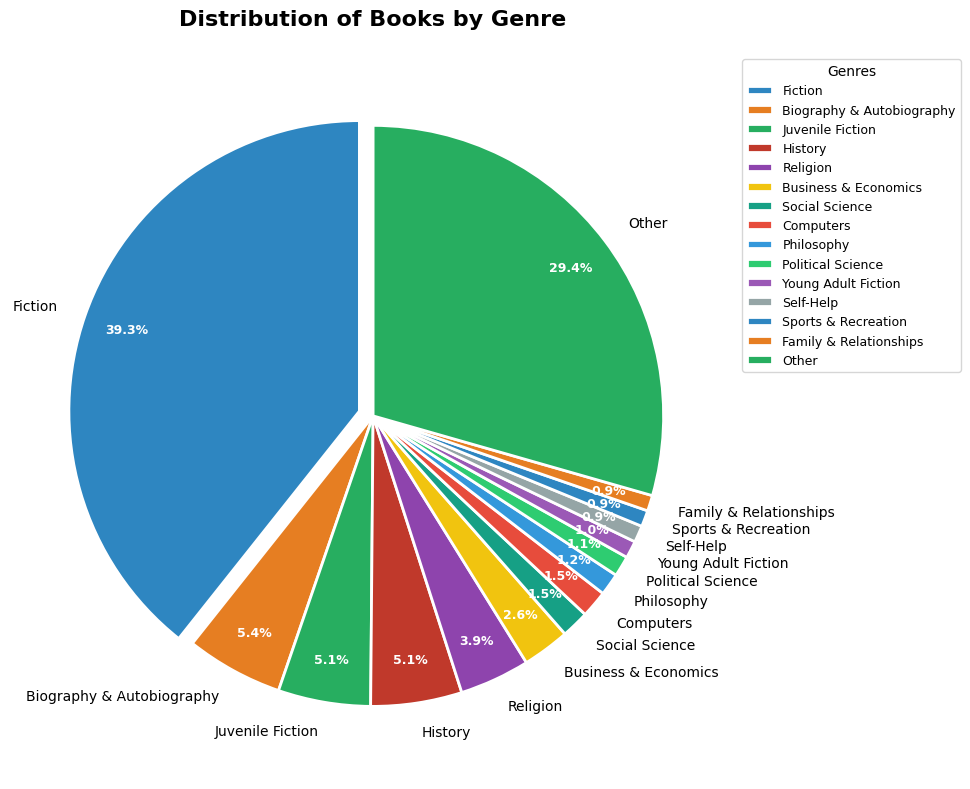

In [ ]:
plot_categories(unique_books_all, min_percent=0.7)

Креираме променлива за визуелизација

In [ ]:
category_visual = unique_books_all.dropna(subset=["categories"])

In [ ]:
# Ги земаме книгите што имаат жанрови кои се повторуваат барем 50 пати
category_visual = category_visual.groupby('categories').filter(lambda x: len(x) > 50)

In [ ]:
category_visual.groupby('categories')['review/score'].count().sort_values(ascending=True).head(10)

categories
Nature                     53
Art                        55
Reference                  55
Performing Arts            58
Poetry                     59
Crafts & Hobbies           59
Education                  62
Comics & Graphic Novels    68
True Crime                 68
Humor                      70
Name: review/score, dtype: int64

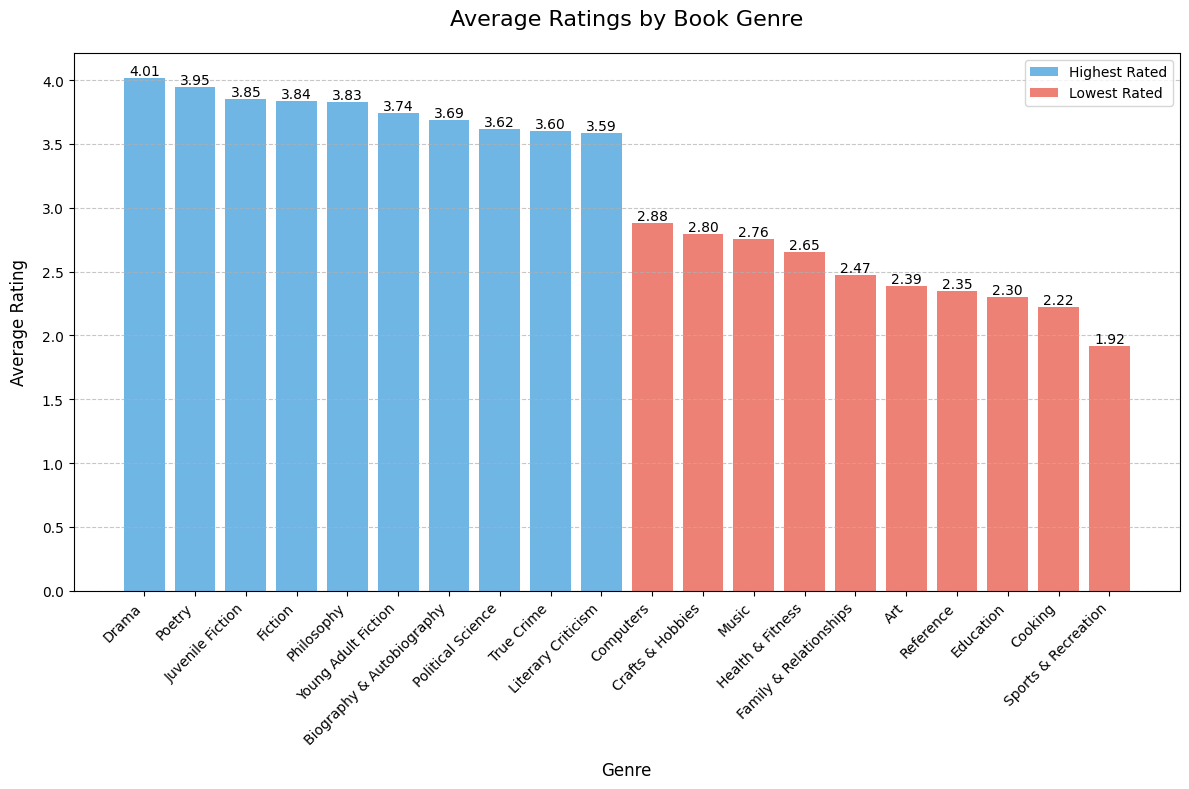

In [ ]:
# Променливи со жанровите со највисока и најниска просечна оценка
avg_cat_rating = category_visual.groupby('categories')['review/score'].mean().sort_values(ascending=False).head(10)
avg_cat_rating_d = category_visual.groupby('categories')['review/score'].mean().sort_values().head(10)

# Поставување на стил
sns.set_palette("husl")

plt.figure(figsize=(12, 8))


bars1 = plt.bar(avg_cat_rating.index, avg_cat_rating,
                color='#3498db', alpha=0.7, label='Highest Rated')
bars2 = plt.bar(avg_cat_rating_d.index, avg_cat_rating_d[::-1],
                color='#e74c3c', alpha=0.7, label='Lowest Rated')

plt.title('Average Ratings by Book Genre', fontsize=16, pad=20)
plt.xlabel('Genre', fontsize=12, labelpad=10)
plt.ylabel('Average Rating', fontsize=12, labelpad=10)

# Ротирање на текстот за подобро читање
plt.xticks(rotation=45, ha='right')


plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout()

plt.legend(loc='upper right', bbox_to_anchor=(1, 1))

# Додавање на точните вредности над столбовите
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.2f}',
                ha='center', va='bottom')

add_value_labels(bars1)
add_value_labels(bars2)


plt.show()

Визуелизација на бројот на рецензии на книги

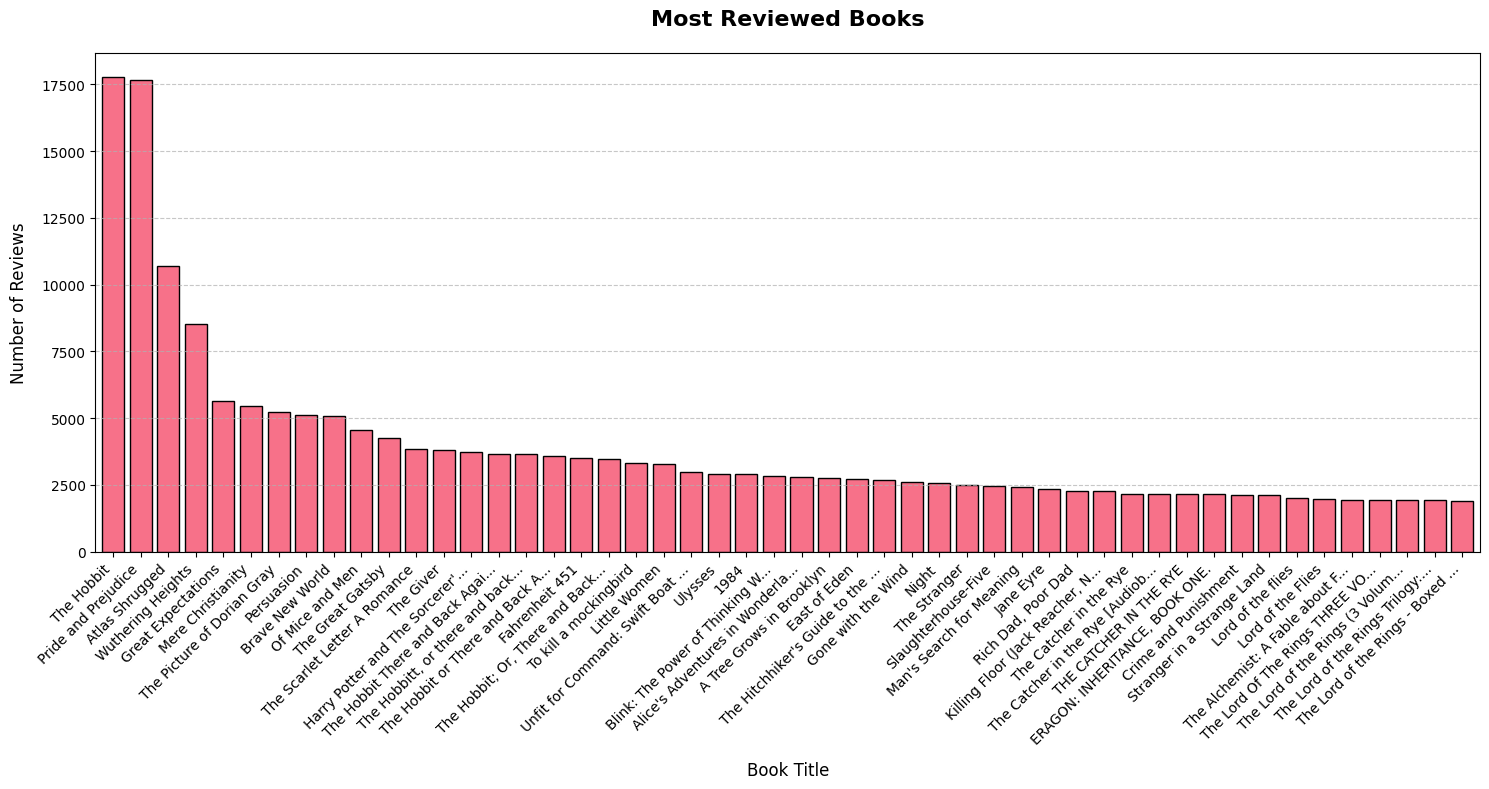

In [ ]:
sns.set_palette("husl")

# Функција за кратење на текст
def truncate_text(text, max_length=30):
    return text[:max_length] + '...' if len(text) > max_length else text

# Земање на книгите со најмногу рецензии и кратење на нивните наслови доколку се големи
data = books.value_counts("Title")[:50]
truncated_index = [truncate_text(title) for title in data.index]
data.index = truncated_index


fig, ax = plt.subplots(figsize=(15, 8))

data.plot(
    kind='bar',
    ax=ax,
    width=0.8,
    edgecolor='black',
    linewidth=1
)

plt.title('Most Reviewed Books', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('Book Title', fontsize=12, labelpad=10)
plt.ylabel('Number of Reviews', fontsize=12, labelpad=10)

# Ротирање на лабели за полесно читање
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()

plt.show()




---



Визуелизација на најактивните корисници во однос на број на рецензии

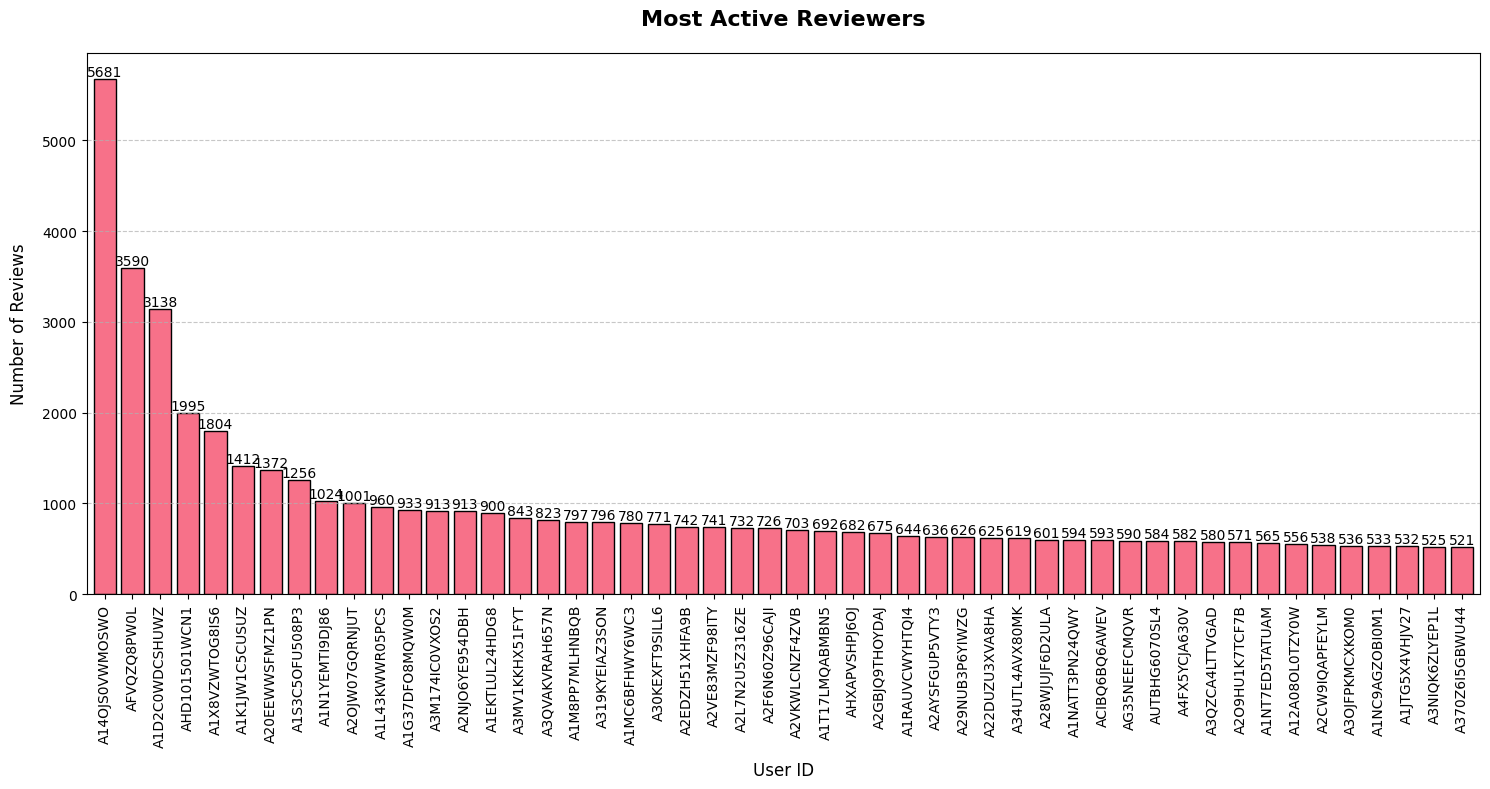

In [ ]:
sns.set_palette("husl")

# Пребарување на најактивните корисници
data = books.value_counts("User_id")[:50]

fig, ax = plt.subplots(figsize=(15, 8))

data.plot(
    kind='bar',
    ax=ax,
    width=0.8,
    edgecolor='black',
    linewidth=1
)


plt.title('Most Active Reviewers', fontsize=16, pad=20, fontweight='bold')
plt.xlabel('User ID', fontsize=12, labelpad=10)
plt.ylabel('Number of Reviews', fontsize=12, labelpad=10)


plt.grid(axis='y', linestyle='--', alpha=0.7)

# Додавање на лабели над столбовите
for i, v in enumerate(data):
    ax.text(i, v, str(v), ha='center', va='bottom')

plt.tight_layout()

plt.show()


---



Графирање на најдобро и најлошо оценетите книги со повеќе од 1000 рецензии

In [ ]:
most_reviewed_books = books.groupby('Title').filter(lambda x: len(x) > 1000)

In [ ]:
# Земање на средните вредности на најдобро и најлошо оценетите книги
average_review_scores = most_reviewed_books.groupby('Title')['review/score'].mean().sort_values(ascending=False).head(25)
average_review_scores_d = most_reviewed_books.groupby('Title')['review/score'].mean().sort_values().head(25)

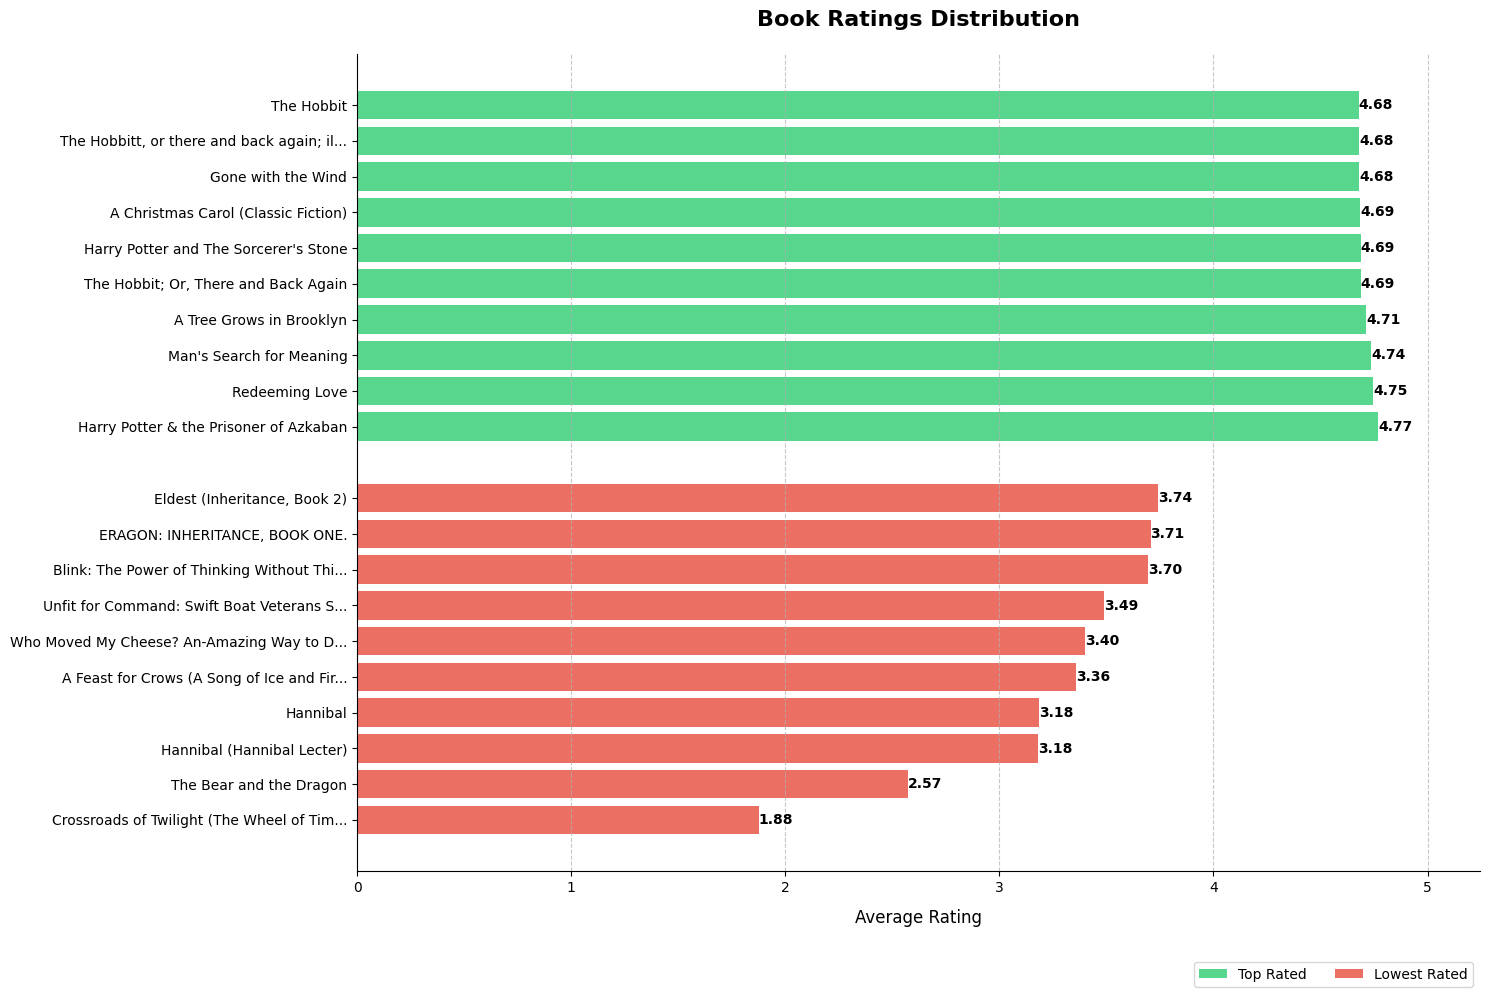

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_book_ratings(top_scores, bottom_scores):

    fig, ax = plt.subplots(figsize=(15, 10))

    # Број на книги
    n_books = len(top_scores)

    # Креирање на позициите за столбовите за книгите
    positions = np.arange(n_books)


    bar_width = 0.8
    top_bars = ax.barh(positions + n_books + 1, top_scores.values,
                       bar_width, label='Top Rated', color='#2ecc71', alpha=0.8)
    bottom_bars = ax.barh(positions, bottom_scores.values,
                         bar_width, label='Lowest Rated', color='#e74c3c', alpha=0.8)


    ax.set_title('Book Ratings Distribution', pad=20, fontsize=16, fontweight='bold')
    ax.set_xlabel('Average Rating', fontsize=12, labelpad=10)

    # Поставување на лабели
    all_positions = np.concatenate([positions, positions + n_books + 1])
    all_titles = np.concatenate([bottom_scores.index, top_scores.index])

    # Кратење на насловите
    max_title_length = 40
    truncated_titles = [title[:max_title_length] + '...' if len(title) > max_title_length else title
                       for title in all_titles]

    ax.set_yticks(all_positions)
    ax.set_yticklabels(truncated_titles, fontsize=10)

    # Поставување на вредностите на колоните
    def add_labels(bars):
        for bar in bars:
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2,
                   f'{width:.2f}',
                   ha='left', va='center', fontsize=10,
                   fontweight='bold')

    add_labels(top_bars)
    add_labels(bottom_bars)

    # Поставки на grid
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)
    ax.grid(False, axis='y')

    # Поставки на границите на табелата
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Поставки за легендата
    ax.legend(loc='lower right', bbox_to_anchor=(1.0, -0.15),
             ncol=2, fontsize=10, frameon=True)

    # Додавање на вредностите од 0 до 5 на x оската
    ax.set_xlim(0, max(top_scores.max(), bottom_scores.max()) * 1.1)


    plt.tight_layout()

    return fig

# Земање на книгите со најмногу рецензии
most_reviewed_books = books.groupby('Title').filter(lambda x: len(x) > 1000)
average_review_scores = most_reviewed_books.groupby('Title')['review/score'].mean()

# Добивање на најдобрите и најлошите 25 книги
top_25 = average_review_scores.sort_values(ascending=False).head(10)
bottom_25 = average_review_scores.sort_values().head(10)

fig = plot_book_ratings(top_25, bottom_25)
plt.show()


###Sentiment Analysis

In [ ]:
if debug:
  to_sample = 10000
else:
  to_sample = 30000

Земаме репрезентативно множество на рецензии врз кои ќе направиме анализа на сентимент

In [ ]:
review_sample = books.sample(to_sample)

In [ ]:
vader = SentimentIntensityAnalyzer()

In [ ]:
# Текстуалната рецензија ја поставуваме со мали букви
review_sample['clean_reviews'] = review_sample['review/text'].str.lower()
# Пресметуваме Polarity Score
review_sample['score'] = review_sample['clean_reviews'].apply(lambda review: vader.polarity_scores(review))
# Екстракција на compound колоната
review_sample['compound']  = review_sample['score'].apply(lambda score_dict: score_dict['compound'])

In [ ]:
review_sample.head(2)

Id                                              Title  \
235837   B0007FQ9W6                                 The cat in the hat   
1480498  B000N67ADQ  Healing the Trauma of Domestic Violence: a Wor...   

                User_id  review/score  review/time  \
235837   A3AGKHXVSUXOMQ           5.0   1016582400   
1480498  A3EN999V25AYUY           5.0   1261353600   

                                            review/summary  \
235837   One Classic that should be in every parents' c...   
1480498                                            Allison   

                                               review/text  \
235837   As a parent of a toddler, I occasionally find ...   
1480498  Fabulous book !! It is right on point about PT...   

                                               description  \
235837   The one and only Cat in the Hat from the iconi...   
1480498  If you've freed yourself from an abusive relat...   

                                                   authors  \
235837                                       ['Dr. Seuss']   
1480498  ['Edward S. Kubany', 'Mari A. McCaig', 'Janet ...   

                                                     image  \
235837   http://books.google.com/books/content?id=2fY9D...   
1480498  http://books.google.com/books/content?id=7o1HA...   

                                       publisher publishedDate  \
235837                          HarperCollins UK    2017-12-01   
1480498  New Harbinger Publications Incorporated       2004-08   

                         categories  \
235837         ['Juvenile Fiction']   
1480498  ['Family & Relationships']   

                                             clean_reviews  \
235837   as a parent of a toddler, i occasionally find ...   
1480498  fabulous book !! it is right on point about pt...   

                                                     score  compound  
235837   {'neg': 0.051, 'neu': 0.809, 'pos': 0.139, 'co...    0.9801  
1480498  {'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'comp...    0.6103

In [ ]:
# Доколку compound вредноста е поголема од 0.05 поставуваме дека сентиментот е позитивен, ако е помал од -0.05 е негативен, а инаку неутрален
review_sample['Sentiment'] = review_sample['compound'].apply(lambda x: 'positive' if x >= 0.05 else 'negative' if x < -0.05 else 'neutral')
review_sample.head(2)

Id                                              Title  \
235837   B0007FQ9W6                                 The cat in the hat   
1480498  B000N67ADQ  Healing the Trauma of Domestic Violence: a Wor...   

                User_id  review/score  review/time  \
235837   A3AGKHXVSUXOMQ           5.0   1016582400   
1480498  A3EN999V25AYUY           5.0   1261353600   

                                            review/summary  \
235837   One Classic that should be in every parents' c...   
1480498                                            Allison   

                                               review/text  \
235837   As a parent of a toddler, I occasionally find ...   
1480498  Fabulous book !! It is right on point about PT...   

                                               description  \
235837   The one and only Cat in the Hat from the iconi...   
1480498  If you've freed yourself from an abusive relat...   

                                                   authors  \
235837                                       ['Dr. Seuss']   
1480498  ['Edward S. Kubany', 'Mari A. McCaig', 'Janet ...   

                                                     image  \
235837   http://books.google.com/books/content?id=2fY9D...   
1480498  http://books.google.com/books/content?id=7o1HA...   

                                       publisher publishedDate  \
235837                          HarperCollins UK    2017-12-01   
1480498  New Harbinger Publications Incorporated       2004-08   

                         categories  \
235837         ['Juvenile Fiction']   
1480498  ['Family & Relationships']   

                                             clean_reviews  \
235837   as a parent of a toddler, i occasionally find ...   
1480498  fabulous book !! it is right on point about pt...   

                                                     score  compound Sentiment  
235837   {'neg': 0.051, 'neu': 0.809, 'pos': 0.139, 'co...    0.9801  positive  
1480498  {'neg': 0.0, 'neu': 0.841, 'pos': 0.159, 'comp...    0.6103  positive

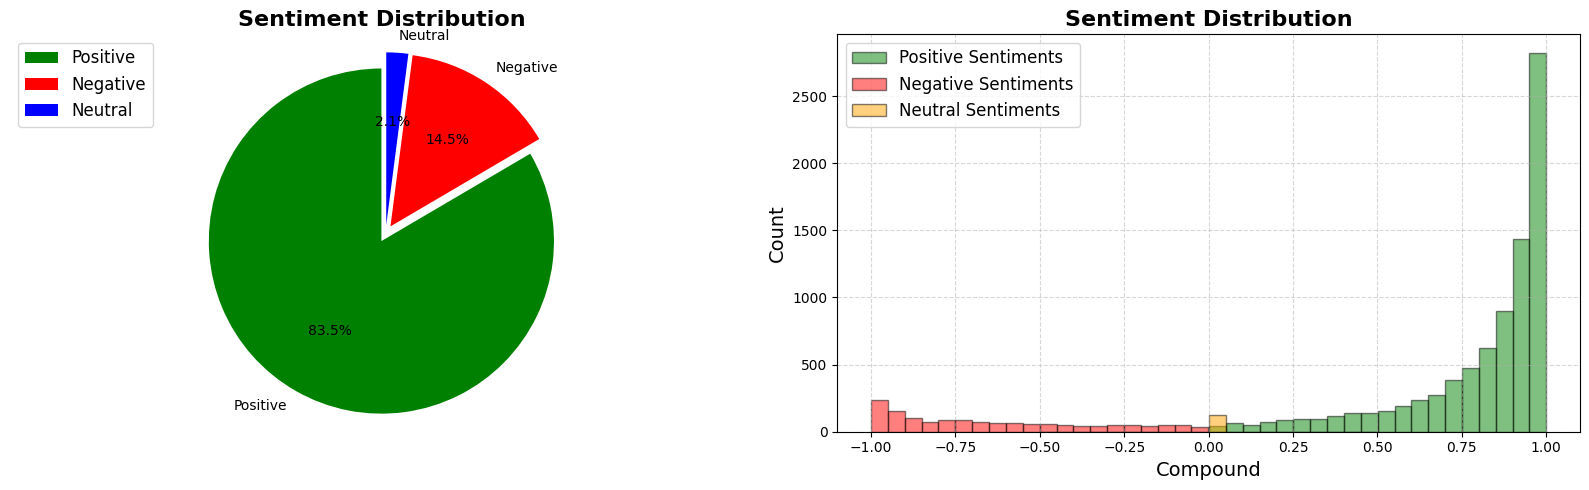

In [ ]:
plt.figure(figsize=(16, 5))

# График 1 - Кружен дијаграм за распределба на сентимент
plt.subplot(1, 2, 1)
labels = ['Positive', 'Negative', 'Neutral']
sizes = review_sample['Sentiment'].value_counts()
colors = ['#008000', '#FF0000', '#0000FF']
explode = (0.05, 0.05, 0.05)

plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Sentiment Distribution', fontsize=16, fontweight='bold')
plt.axis('equal')  # Equal aspect ratio ensures that pie is circular.
plt.legend(labels, loc='upper left', fontsize=12, framealpha=0.8)

# График 2 - Хистограм за распределба на сентимент
plt.subplot(1, 2, 2)
positive = review_sample[review_sample['compound'] > 0]['compound']
negative = review_sample[review_sample['compound'] < 0]['compound']
neutral = review_sample[review_sample['compound'] == 0]['compound']

sentiments = [positive, negative, neutral]
colors = ['#008000', '#FF0000', '#FFA500']
labels = ['Positive Sentiments', 'Negative Sentiments', 'Neutral Sentiments']

for sentiment, color, label in zip(sentiments, colors, labels):
    plt.hist(sentiment, bins=20, color=color, alpha=0.5, label=label, edgecolor='black', linewidth=1)

plt.title('Sentiment Distribution', fontsize=16, fontweight='bold')
plt.xlabel('Compound', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.legend(loc='upper left', fontsize=12, framealpha=0.8)
plt.grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


###Feature extraction

In [ ]:
unique_books_3 = unique_books_3.reset_index(drop=True)

In [ ]:
#Ги отстрануваме колоните кои нема да ги употребуваме
unique_books_3 = unique_books_3.drop(["Id","User_id","review/score","review/time","review/summary","review/text","image","publishedDate"],axis=1)

In [ ]:
unique_books_3.head(5)

Title  \
0                                   The Food Of Love   
1                   The Scarletti Curse (Candleglow)   
2  Cruel and Unusual (G K Hall Large Print Book S...   
3                                    The Rabbi's Cat   
4                                From Potter's Field   

                                         description            authors  \
0  Een heerlijke roman over culinaire verleiding ...    Anthony Capella   
1                                                NaN   Christine Feehan   
2  Wanneer er in dit achtste deel in de Kay Scarp...  Patricia Cornwell   
3  Gaining the ability to speak after swallowing ...         Joann Sfar   
4  The sixth book in the Kay Scarpetta series, fr...  Patricia Cornwell   

           publisher               categories  
0           Boekerij                  Fiction  
1                NaN                      NaN  
2  Luitingh Sijthoff                  Fiction  
3           Pantheon  Comics & Graphic Novels  
4        Hachette UK                  Fiction

In [ ]:
id_to_book_title_3 = {}
book_title_to_id_3 = {}

In [ ]:
# За секоја уникатна книга доделуваме специфична бројка во dict, овие бројки подоцна ќе станат идентификатори за јазли
for i, row in enumerate(unique_books_3.values):

  id_to_book_title_3[i] = row[0]
  book_title_to_id_3[row[0]] = i

In [ ]:
id_to_book_title_3

{0: 'The Food Of Love',
 1: 'The Scarletti Curse (Candleglow)',
 2: 'Cruel and Unusual (G K Hall Large Print Book Series (Cloth))',
 3: "The Rabbi's Cat",
 4: "From Potter's Field",
 5: 'Lincoln reconsidered;: Essays on the Civil War era',
 6: 'Economics in one lesson',
 7: 'Tales from silver lands',
 8: 'Edge of Danger',
 9: 'The Scarlet Letter A Romance',
 10: 'Olympic Wandering: Time Travel Through Greece',
 11: "Plain And Simple - A Woman's Journey To The Amish",
 12: 'Napoleon (A Mentor book)',
 13: 'Thomas Paine : Collected Writings : Common Sense / The Crisis / Rights of Man / The Age of Reason / Pamphlets, Articles, and Letters (Library of America)',
 14: 'The Castle in the Attic',
 15: 'Outposts',
 16: 'Island',
 17: 'Life with father',
 18: 'After the Fire (Chivers Sound Library)',
 19: 'Stuck with You (Time of Your Life)',
 20: 'Dumb witness',
 21: 'Professional collection catalog',
 22: "Lenin's Tomb: The Last Days of the Soviet Empire",
 23: "Dr. Bernstein's Diabetes Solut

Создаваме 3 LabelEncoder објекти за да доделиме уникатни вредности за категориските информации во publisher, authors и categories колоната.

In [ ]:
encoder = LabelEncoder()

encoder.fit(unique_books_3["publisher"])

unique_books_3["publisher_id"] = encoder.transform(unique_books_3["publisher"])

In [ ]:
encoder = LabelEncoder()

encoder.fit(unique_books_3["authors"])

unique_books_3["author_id"] = encoder.transform(unique_books_3["authors"])

In [ ]:
encoder = LabelEncoder()

encoder.fit(unique_books_3["categories"])

unique_books_3["category_id"] = encoder.transform(unique_books_3["categories"])


In [ ]:
unique_books_3.head(2)

Title  \
0                  The Food Of Love   
1  The Scarletti Curse (Candleglow)   

                                         description           authors  \
0  Een heerlijke roman over culinaire verleiding ...   Anthony Capella   
1                                                NaN  Christine Feehan   

  publisher categories  publisher_id  author_id  category_id  
0  Boekerij    Fiction           186        329          355  
1       NaN        NaN          1421        845          629

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
model = RobertaModel.from_pretrained('roberta-base')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Функција за пресметување на средна вредност на embeddings за наслов или опис
def compute_embeddings(texts):
    embeddings_list = []

    batch_size = 1000

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        print(f"Currently processing {i}")
        # Токенизирање и препроцесирање на текстовите
        tokenized_texts = [tokenizer.encode(text, add_special_tokens=True, truncation = True, max_length=512) for text in batch_texts.astype(str)]

        # Padding или кратење на токенизирани секвенци до одредена големина
        max_length = 128
        padded_texts = [text[:max_length] + [tokenizer.pad_token_id] * (max_length - len(text[:max_length])) for text in tokenized_texts]

        # Претворање во PyTorch Tensor објект
        input_ids = torch.tensor(padded_texts).to(device)

        # Генерирање на RoBERTa embeddings
        with torch.no_grad():
            outputs = model(input_ids)
            embeddings = outputs.last_hidden_state[:, 0, :].to(device)

        embeddings_list.extend(embeddings.cpu().numpy())

    return embeddings_list



/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
book_features_3 = unique_books_3[['publisher_id', 'author_id', 'category_id']].copy()

In [ ]:
title_embeddings = compute_embeddings(unique_books_3["Title"])
description_embeddings = compute_embeddings(unique_books_3["description"])

Currently processing 0


We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Currently processing 1000
Currently processing 2000
Currently processing 3000
Currently processing 4000
Currently processing 5000
Currently processing 6000
Currently processing 7000
Currently processing 8000
Currently processing 9000
Currently processing 10000
Currently processing 11000
Currently processing 0
Currently processing 1000
Currently processing 2000
Currently processing 3000
Currently processing 4000
Currently processing 5000
Currently processing 6000
Currently processing 7000
Currently processing 8000
Currently processing 9000
Currently processing 10000
Currently processing 11000


In [ ]:
title_embeddings_df = pd.DataFrame(title_embeddings)
description_embeddings_df = pd.DataFrame(description_embeddings)

In [ ]:
title_embeddings_df.to_csv("title_embeddings.csv")
description_embeddings_df.to_csv("description_embeddings.csv")

In [ ]:
# Ја намалуваме димензионалноста на RoBERTa embeddings користејќи PCA Декомпозиција
from sklearn.decomposition import PCA

title_embeddings_number = 4
description_embeddings_number = 16

###

# Креирање на PCA објект
pca_title = PCA(n_components=title_embeddings_number)

# Фитирање на PCA моделот
reduced_embeddings_title = pca_title.fit_transform(title_embeddings_df)

###

pca_description = PCA(n_components=description_embeddings_number)

reduced_embeddings_description = pca_description.fit_transform(description_embeddings_df)

In [ ]:
reduced_embeddings_title_df = pd.DataFrame(reduced_embeddings_title)
reduced_embeddings_description_df = pd.DataFrame(reduced_embeddings_description)

In [ ]:
# Реименување на колоните на embedding dataframes
for i in range(title_embeddings_number):
  reduced_embeddings_title_df.rename(columns={i:f"title_embedding_{i}"}, inplace=True)

for i in range(description_embeddings_number):
  reduced_embeddings_description_df.rename(columns={i:f"description_embedding_{i}"}, inplace=True)

In [ ]:
reduced_embeddings_title_df.head()

title_embedding_0  title_embedding_1  title_embedding_2  title_embedding_3
0          -0.506977           0.236704           0.046287           0.009054
1           1.137828           0.724696          -0.162736          -0.039598
2          -0.426461          -0.003376          -0.723814          -0.431960
3           0.083249           0.681182           0.514402          -0.137258
4          -1.082706           0.008359           0.054873          -0.039049

In [ ]:
reduced_embeddings_description_df.head()

description_embedding_0  description_embedding_1  description_embedding_2  \
0                 0.593495                -0.258801                -0.204791   
1                -1.840728                -0.307196                 0.214182   
2                 0.786140                -0.344028                -0.123202   
3                -0.097258                 0.957670                -0.413291   
4                 0.187113                -0.613967                -0.578979   

   description_embedding_3  description_embedding_4  description_embedding_5  \
0                -0.155537                 0.101335                -0.009702   
1                -0.107987                 0.055829                 0.043263   
2                -0.113396                 0.075455                 0.048714   
3                -0.356299                -0.563403                 0.114121   
4                -0.032874                -0.047319                -0.069298   

   description_embedding_6  description_embedding_7  description_embedding_8  \
0                 0.085881                -0.159045                -0.172853   
1                 0.010360                -0.006107                -0.005703   
2                 0.157881                -0.155250                -0.160301   
3                -0.045359                 0.020641                -0.118139   
4                -0.217250                -0.006265                -0.079529   

   description_embedding_9  description_embedding_10  \
0                -0.604203                 -0.229928   
1                 0.005859                 -0.001970   
2                -0.576646                 -0.193402   
3                 0.146047                 -0.153870   
4                -0.052453                  0.090540   

   description_embedding_11  description_embedding_12  \
0                  0.061406                  0.230366   
1                  0.002537                  0.006158   
2                  0.052109                  0.189820   
3                 -0.031678                 -0.067856   
4                 -0.011662                 -0.063019   

   description_embedding_13  description_embedding_14  \
0                  0.119940                 -0.463603   
1                 -0.005369                  0.002049   
2                  0.111694                 -0.485520   
3                 -0.014139                  0.006077   
4                 -0.132709                  0.048930   

   description_embedding_15  
0                  0.294486  
1                 -0.000582  
2                  0.343577  
3                  0.037619  
4                 -0.026108

In [ ]:
#Комбинирање на веќе постоечките својства за книги во една променлива
result_book_features_3 = pd.concat([book_features_3, reduced_embeddings_description_df, reduced_embeddings_title_df], axis=1)

In [ ]:
result_book_features_3

publisher_id  author_id  category_id  description_embedding_0  \
0               186        329          355                 0.593495   
1              1421        845          629                -1.840728   
2               744       3861          355                 0.786140   
3               931       2454          238                -0.097258   
4               520       3861          355                 0.187113   
...             ...        ...          ...                      ...   
11580           917       2908          472                 1.066419   
11581          1421       5220          355                 0.319071   
11582          1217        688          453                -1.061538   
11583          1321       3988          355                 0.013512   
11584          1075       5070          588                 0.741904   

       description_embedding_1  description_embedding_2  \
0                    -0.258801                -0.204791   
1                    -0.307196                 0.214182   
2                    -0.344028                -0.123202   
3                     0.957670                -0.413291   
4                    -0.613967                -0.578979   
...                        ...                      ...   
11580                -0.435162                 0.027213   
11581                 0.946062                 0.079706   
11582                 0.138934                -0.661633   
11583                 1.455774                -0.149977   
11584                 0.278496                -0.016789   

       description_embedding_3  description_embedding_4  \
0                    -0.155537                 0.101335   
1                    -0.107987                 0.055829   
2                    -0.113396                 0.075455   
3                    -0.356299                -0.563403   
4                    -0.032874                -0.047319   
...                        ...                      ...   
11580                 0.058993                -0.106533   
11581                 0.449535                 0.070660   
11582                 0.762731                -0.489919   
11583                -0.414754                -0.562882   
11584                -0.394931                -0.387003   

       description_embedding_5  description_embedding_6  ...  \
0                    -0.009702                 0.085881  ...   
1                     0.043263                 0.010360  ...   
2                     0.048714                 0.157881  ...   
3                     0.114121                -0.045359  ...   
4                    -0.069298                -0.217250  ...   
...                        ...                      ...  ...   
11580                 0.233556                 0.231494  ...   
11581                 0.202819                 0.241696  ...   
11582                -0.551988                 0.165722  ...   
11583                 0.115520                -0.043762  ...   
11584                -0.051869                 0.432630  ...   

       description_embedding_10  description_embedding_11  \
0                     -0.229928                  0.061406   
1                     -0.001970                  0.002537   
2                     -0.193402                  0.052109   
3                     -0.153870                 -0.031678   
4                      0.090540                 -0.011662   
...                         ...                       ...   
11580                  0.000248                 -0.093479   
11581                 -0.184969                  0.079633   
11582                 -0.120998                  0.085712   
11583                 -0.001045                 -0.026054   
11584                  0.034275                 -0.101234   

       description_embedding_12  description_embedding_13  \
0                      0.230366                  0.119940   
1                      0.006158                 -0.005369   
2                      0.189820        

### Creating knowledge graph

In [ ]:
id_to_user_id_3 = {}
user_id_to_id_3 = {}

In [ ]:
unique_users_3 = books_filtered["User_id"].unique()

In [ ]:
# Слично како претходно, креирање на мапа за добивање на уникатна нумерична вредност за секој корисник која ќе се користи како id за јазол во графот
for i, user in enumerate(unique_users_3):
  id_to_user_id_3[i] = user
  user_id_to_id_3[user] = i

In [ ]:
books_filtered["book_node_id"] = books_filtered["Title"].map(book_title_to_id_3)

In [ ]:
books_filtered["user_node_id"] = books_filtered["User_id"].map(user_id_to_id_3)

In [ ]:
books_filtered.head(2)

Id             Title         User_id  review/score  review/time  \
3  B000N7612G  The Food Of Love  A2V6FC7GVZ6T7M           5.0   1285459200   
4  B000N7612G  The Food Of Love  A1ZMXRS5770YKG           4.0   1269648000   

     review/summary                                        review/text  \
3  The Food of Love  A tale of tangled relationships and excellent ...   
4  A Taste of Italy  Longing for vicarious travel? Imagining your c...   

                                         description          authors  \
3  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
4  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   

                                               image publisher publishedDate  \
3  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
4  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   

  categories  book_node_id  user_node_id  
3    Fiction             0             0  
4    Fiction             0             1

In [ ]:
# Креирање на репрезентацијата на ребрата во графот, tensor кој содржи 2 други tensor-и, ребро постои помеѓу i-тиот јазол во првиот подтенсор, и i-тиот јазол во вториот.
review_edges_3 = torch.stack([torch.from_numpy(books_filtered["user_node_id"].values),
                            torch.from_numpy(books_filtered["book_node_id"].values)])

In [ ]:
# зачувување во датотека за подоцна да се употреби во Flask
torch.save(review_edges_3,"review_edges.pt")

In [ ]:
review_edges_3

tensor([[    0,     1,     2,  ...,   916, 14268,  1330],
        [    0,     0,     0,  ...,  5306,  5306,  5306]])

In [ ]:
# слично, зачувување на мапата
import pickle
with open('saved_dictionary.pkl', 'wb') as f:
    pickle.dump(user_id_to_id_3, f)

In [ ]:
result_book_features_3.to_csv("book_features.csv")

#### Креирање PyTorch HeteroData објект

In [ ]:
data_3 = HeteroData()

# Додавање на јазли во графот, колку што има уникатни книги и уникатни корисници (+ 10 за да можеме да дотренираме понатаму со моменталниот корисник)
data_3["book"].node_id = torch.arange(len(unique_books_3))
data_3["user"].node_id = torch.arange(len(user_id_to_id_3) + 10)

# Додавање на својствата на книгите
data_3["book"].x = tensor(result_book_features_3.values, dtype=torch.float)


data_3["user","review","book"].edge_index = review_edges_3

# Претворање на графот во ненасочен граф
data_3 = T.ToUndirected()(data_3)
data_3

# Проверување на исправноста на графот
assert data_3['user'].num_nodes == len(id_to_user_id_3) +10
assert data_3["book"].num_features == 23
assert data_3['user'].num_features == 0

In [ ]:
import networkx as nx
import plotly.graph_objects as go
import random
from tqdm import tqdm
import numpy as np

def visualize_bipartite_graph(data, n_samples=1000, figsize=(1400, 900), seed=42):
    """
    Цртање на бипартитен граф
    """
    random.seed(seed)
    np.random.seed(seed)


    n_users = len(data["user"].node_id)
    n_books = len(data["book"].node_id)

    # Земање на дел од графот
    sampled_users = random.sample(range(n_users), min(n_samples, n_users))
    sampled_books = random.sample(range(n_books), min(n_samples, n_books))

    user_set = set(sampled_users)
    book_set = set(sampled_books)

    # Креирање на листа од јазли
    user_nodes = [f"U{i}" for i in sampled_users]
    book_nodes = [f"B{i}" for i in sampled_books]


    pos = {}


    max_nodes = max(len(user_nodes), len(book_nodes))
    spacing = 1.8 / max_nodes  # Креирање на простор помеѓу јазлите

    # Позиционирање на јазлите на левата страна
    user_offset = (max_nodes - len(user_nodes)) * spacing / 2
    for i, node in enumerate(user_nodes):
        y_pos = -0.9 + user_offset + (i * spacing)

        y_offset = random.uniform(-spacing * 0.1, spacing * 0.1)
        pos[node] = np.array([-1.0, y_pos + y_offset])

    # Позиционирање на јазлите на десната страна
    book_offset = (max_nodes - len(book_nodes)) * spacing / 2
    for i, node in enumerate(book_nodes):
        y_pos = -0.9 + book_offset + (i * spacing)

        y_offset = random.uniform(-spacing * 0.1, spacing * 0.1)
        pos[node] = np.array([1.0, y_pos + y_offset])

    # Броење на број на врски на јазолот за да се одреди големина
    node_edges = {node: 0 for node in user_nodes + book_nodes}
    edges = []
    edge_weights = {}
    edges_raw = data["user", "review", "book"].edge_index.t().numpy()

    for user_id, book_id in edges_raw:
        if user_id in user_set and book_id in book_set:
            user_node = f"U{user_id}"
            book_node = f"B{book_id}"
            edge = (user_node, book_node)
            edges.append(edge)
            edge_weights[edge] = edge_weights.get(edge, 0) + 1
            node_edges[user_node] += 1
            node_edges[book_node] += 1


    fig = go.Figure()


    fig.add_shape(
        type="rect",
        x0=-1.5,
        x1=1.5,
        y0=-1,
        y1=1,
        fillcolor="white",
        layer="below",
        line_width=0,
    )

    # Додавање на ребрата
    max_edge_weight = max(edge_weights.values())
    for (u, v) in tqdm(edges, desc="Adding edges"):
        weight = edge_weights[(u, v)]
        opacity = 0.15 + 0.25 * (weight / max_edge_weight)  # Reduced opacity range
        width = 0.5 + 0.5 * (weight / max_edge_weight)  # Thinner edges

        fig.add_trace(go.Scatter(
            x=[pos[u][0], pos[v][0]],
            y=[pos[u][1], pos[v][1]],
            mode='lines',
            line=dict(
                color=f'rgba(100, 149, 237, {opacity})',
                width=width,
                shape='spline'
            ),
            showlegend=False,
            hoverinfo='none'
        ))

    # Одредување големина на јазол
    def get_node_size(node):
        min_size = 20  # Smaller minimum size
        max_size = 60  # Smaller maximum size
        edge_count = node_edges[node]
        max_edges = max(node_edges.values())
        size = min_size + (max_size - min_size) * np.sqrt(edge_count / max_edges)  # Square root for better size distribution
        return size

    # Додавање на кориснички јазли во графикот
    user_sizes = [get_node_size(node) for node in user_nodes]
    fig.add_trace(go.Scatter(
        x=[pos[n][0] for n in user_nodes],
        y=[pos[n][1] for n in user_nodes],
        mode='markers',
        marker=dict(
            color='rgb(25, 118, 210)',
            size=user_sizes,
            line=dict(color='white', width=1),
            symbol='circle',
            opacity=0.9,
            gradient=dict(
                type='radial',
                color='rgb(13, 71, 161)'
            )
        ),
        name=f'Users (n={len(user_nodes)})',
        hovertemplate='User %{y}<extra></extra>'
    ))

    # Додавање на јазли за книги во графикот
    book_sizes = [get_node_size(node) for node in book_nodes]
    fig.add_trace(go.Scatter(
        x=[pos[n][0] for n in book_nodes],
        y=[pos[n][1] for n in book_nodes],
        mode='markers',
        marker=dict(
            color='rgb(56, 142, 60)',
            size=book_sizes,
            line=dict(color='white', width=1),
            symbol='diamond',
            opacity=0.9,
            gradient=dict(
                type='radial',
                color='rgb(27, 94, 32)'
            )
        ),
        name=f'Books (n={len(book_nodes)})',
        hovertemplate='Book %{y}<extra></extra>'
    ))

    fig.add_shape(
        type="rect",
        x0=-1.2,
        x1=-0.8,
        y0=-0.95,
        y1=0.95,
        fillcolor="rgba(25, 118, 210, 0.05)",
        line_color="rgba(25, 118, 210, 0.15)",
        layer="below"
    )

    fig.add_shape(
        type="rect",
        x0=0.8,
        x1=1.2,
        y0=-0.95,
        y1=0.95,
        fillcolor="rgba(56, 142, 60, 0.05)",
        line_color="rgba(56, 142, 60, 0.15)",
        layer="below"
    )

    fig.update_layout(
        title=dict(
            text='User-Book Interaction Network',
            x=0.5,
            y=0.97,
            xanchor='center',
            yanchor='top',
            font=dict(
                size=28,
                family='Arial',
                color='rgb(30, 30, 30)'
            )
        ),
        showlegend=True,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01,
            bgcolor="rgba(255, 255, 255, 0.95)",
            bordercolor="rgba(0, 0, 0, 0.1)",
            borderwidth=1,
            font=dict(
                family='Arial',
                size=14,
                color='rgb(30, 30, 30)'
            )
        ),
        width=figsize[0],
        height=figsize[1],
        plot_bgcolor='white',
        paper_bgcolor='white',
        xaxis=dict(
            visible=False,
            range=[-1.5, 1.5],
            showgrid=False,
        ),
        yaxis=dict(
            visible=False,
            range=[-1, 1],
            showgrid=False,
        ),
        margin=dict(b=20, l=20, r=20, t=80)
    )

    return fig

if debug:
  fig = visualize_bipartite_graph(data_3, n_samples=3000)
  fig.show()

Adding edges: 100%|██████████| 13666/13666 [00:13<00:00, 1043.77it/s]


In [ ]:
data_3.validate()

True

In [ ]:
data_3

HeteroData(
  book={
    node_id=[11585],
    x=[11585, 23],
  },
  user={ node_id=[24685] },
  (user, review, book)={ edge_index=[2, 496857] },
  (book, rev_review, user)={ edge_index=[2, 496857] }
)

#Data processing

##Loading Data

In [ ]:
# Кои ребра сакаме да ги предвидуваме, ние имаме ненасочен граф па го земаме и спротивното ребро
target_edge = ("user","review","book")
rev_target_edge = ("book","rev_review","user")

In [ ]:
# Го делиме нашето податочно множество во тренинг, валидациско и тест множество
# 80% - train
# 10% - validation
# 10% - test

transform = T.RandomLinkSplit(
    num_val=0.1,
    num_test=0.1,
    disjoint_train_ratio=0.3,
    neg_sampling_ratio=2.0,
    add_negative_train_samples=False,
    edge_types=[target_edge],
    rev_edge_types=[rev_target_edge],
)

In [ ]:
train_data_3, val_data_3, test_data_3 = transform(data_3)
print("Training data:")
print("==============")
print(train_data_3)
print()
print("Validation data:")
print("================")
print(val_data_3)
print("Test data:")
print("================")
print(test_data_3)

Training data:
HeteroData(
  book={
    node_id=[11585],
    x=[11585, 23],
  },
  user={ node_id=[24685] },
  (user, review, book)={
    edge_index=[2, 278241],
    edge_label=[119246],
    edge_label_index=[2, 119246],
  },
  (book, rev_review, user)={ edge_index=[2, 278241] }
)

Validation data:
HeteroData(
  book={
    node_id=[11585],
    x=[11585, 23],
  },
  user={ node_id=[24685] },
  (user, review, book)={
    edge_index=[2, 397487],
    edge_label=[149055],
    edge_label_index=[2, 149055],
  },
  (book, rev_review, user)={ edge_index=[2, 397487] }
)
Test data:
HeteroData(
  book={
    node_id=[11585],
    x=[11585, 23],
  },
  user={ node_id=[24685] },
  (user, review, book)={
    edge_index=[2, 447172],
    edge_label=[149055],
    edge_label_index=[2, 149055],
  },
  (book, rev_review, user)={ edge_index=[2, 447172] }
)


In [ ]:
train_data_3.validate()

True

In [ ]:
val_data_3.validate()

True

In [ ]:
test_data_3.validate()

True

In [ ]:
edge_label_index_3 = train_data_3[target_edge].edge_label_index
edge_label_3 = train_data_3[target_edge].edge_label

# Mini-batching на графот за да намалиме користењето на меморија
train_loader_3 = LinkNeighborLoader(
    data=train_data_3,
    num_neighbors=[50,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(target_edge, edge_label_index_3),
    edge_label=edge_label_3,
    batch_size=500,
    shuffle=True,
)


In [ ]:
# Поставуваме моделите да користат GPU доколку е дозволено
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## GraphSAGE

In [ ]:
from torch import Tensor
from torch_geometric.nn import SAGEConv, to_hetero
import torch.nn as nn

class GraphSAGE_3(torch.nn.Module):
    def __init__(self, hidden_channels,dropout=.3):
        super().__init__()

        # Иницијализација на двата слоја SAGEConv и помеѓу нив Dropout
        self.conv1 = SAGEConv(hidden_channels, hidden_channels)
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = SAGEConv(hidden_channels, hidden_channels)


    def forward(self, x, edge_index):
        # Функцијата за forward pass
        x = self.conv1(x, edge_index).relu()
        x = self.dropout1(x)
        x = self.conv2(x, edge_index)
        return x

class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_book: Tensor, edge_label_index: Tensor) -> Tensor:
        # Земање на embedding векторот на јазолот за корисникот и за книгата:

        edge_feat_user = x_user[edge_label_index[0]].to(dtype=x_book.dtype)
        edge_feat_book = x_book[edge_label_index[1]]

        # Пресметување на скаларен производ помеѓу карактеристиките на корисникот и книгата
        return (edge_feat_user * edge_feat_book).sum(dim=-1)

class SAGEModel_3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        # Бидејќи податочното множество не содржи многу податоци за својствата на книгите и корисниците,
        # паралелно со тренирањето учиме и две embedding матрици за корисници и книги:

        self.user_emb = torch.nn.Embedding(data_3["user"].num_nodes, hidden_channels)
        self.book_emb = torch.nn.Embedding(data_3["book"].num_nodes, hidden_channels)

        # Инстанцирање на GNN:
        self.gnn = GraphSAGE_3(hidden_channels)

        # Претворање на GNN моделот во хетероген модел:
        self.gnn = to_hetero(self.gnn, metadata=data_3.metadata())

        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "book": self.book_emb(data["book"].node_id),
        }

        # `x_dict` содржи feature матрици за сите типови на јазли
        # `data.edge_index_dict` содржи сите индекси на јазли за сите типови на ребра

        x_dict = self.gnn(x_dict, data.edge_index_dict)


        pred = self.classifier(
            x_dict["user"],
            x_dict["book"],
            data["user", "review", "book"].edge_label_index,
        )

        return pred



In [ ]:
sageModel_3 = SAGEModel_3(hidden_channels=64).to(device)

print(sageModel_3)

SAGEModel_3(
  (user_emb): Embedding(24685, 64)
  (book_emb): Embedding(11585, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__book): SAGEConv(64, 64, aggr=mean)
      (book__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
    (dropout1): ModuleDict(
      (book): Dropout(p=0.3, inplace=False)
      (user): Dropout(p=0.3, inplace=False)
    )
    (conv2): ModuleDict(
      (user__review__book): SAGEConv(64, 64, aggr=mean)
      (book__rev_review__user): SAGEConv(64, 64, aggr=mean)
    )
  )
  (classifier): Classifier()
)


In [ ]:
data_3.metadata()

(['book', 'user'],
 [('user', 'review', 'book'), ('book', 'rev_review', 'user')])

In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
print(f"Device: '{device}'")


optimizer = torch.optim.Adam(sageModel_3.parameters(), lr=0.0001)

# Користиме Binary Cross-Entropy затоа што предвидување постоење (или непостоење) на нешто
loss_fn = torch.nn.BCELoss()

for epoch in range(1, 10):
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader_3):
        optimizer.zero_grad()  # Ресетирање на градиентот на оптимизаторот

        sampled_data.to(device)

        pred = sageModel_3(sampled_data)
        pred = torch.nn.Sigmoid()(pred)  # Претворање на logits во нормализирана веројатност (реален број од 0 до 1)

        ground_truth = sampled_data[target_edge].edge_label  # Добивање на вистинската состојба на реброто
        loss = loss_fn(pred, ground_truth)  # Пресметување на loss од предвидувањето и вистинската состојба


        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()

    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 239/239 [00:08<00:00, 27.91it/s]


Epoch: 001, Loss: 0.6619


100%|██████████| 239/239 [00:08<00:00, 27.00it/s]


Epoch: 002, Loss: 0.5865


100%|██████████| 239/239 [00:06<00:00, 36.34it/s]


Epoch: 003, Loss: 0.5479


100%|██████████| 239/239 [00:06<00:00, 38.58it/s]


Epoch: 004, Loss: 0.5215


100%|██████████| 239/239 [00:08<00:00, 29.42it/s]


Epoch: 005, Loss: 0.4993


100%|██████████| 239/239 [00:09<00:00, 24.54it/s]


Epoch: 006, Loss: 0.4823


100%|██████████| 239/239 [00:05<00:00, 41.97it/s]


Epoch: 007, Loss: 0.4659


100%|██████████| 239/239 [00:08<00:00, 28.45it/s]


Epoch: 008, Loss: 0.4518


100%|██████████| 239/239 [00:08<00:00, 27.80it/s]

Epoch: 009, Loss: 0.4402


In [ ]:
# Дефинирање на ребрата за валидација:
edge_label_index_3 = val_data_3[target_edge].edge_label_index
edge_label_3 = val_data_3[target_edge].edge_label

val_loader = LinkNeighborLoader(
    data=val_data_3,
    num_neighbors=[20, 5],
    edge_label_index=(target_edge, edge_label_index_3),
    edge_label=edge_label_3,
    batch_size=500,
    shuffle=False,
)



In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
edges = []
for sampled_data in tqdm(val_loader):
    with torch.no_grad():  # Го поставуваме ова за да не пресметуваме градиент при предвидување
        edges.append(sampled_data.edge_index_dict[target_edge])
        sampled_data.to(device)

        out = sageModel_3(sampled_data)
        p = torch.sigmoid(sageModel_3(sampled_data))

        preds.append(p)
        ground_truths.append(sampled_data[target_edge].edge_label)

100%|██████████| 299/299 [00:05<00:00, 55.38it/s]


In [ ]:
# Пресметување на ROC-AUC според предвидувањата
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.8206


In [ ]:
from sklearn.metrics import roc_curve

def plot_roc(model_name):


  sns.set_palette("husl")

  # Пресметување на точките на ROC кривата
  fpr, tpr, _ = roc_curve(ground_truth, pred)


  fig, ax = plt.subplots(figsize=(6, 6))

  # Цртање на кривата
  ax.plot(fpr, tpr, color='#2E86C1', lw=2.5, label=f'ROC curve (AUC = {auc:.4f})')
  ax.fill_between(fpr, tpr, alpha=0.2, color='#2E86C1')

  # Цртање на линијата што претставува случајно погодување (1/2 веројатност за двете класи)
  ax.plot([0, 1], [0, 1], '--', color='#7B7D7D', alpha=0.8, lw=1.5, label='Random')

  # Цртање на мал график
  ax.set_xlim([-0.01, 1.01])
  ax.set_ylim([-0.01, 1.01])

  # Додавање на лабели со сопствен стил
  ax.set_xlabel('False Positive Rate', fontsize=12, fontweight='bold', labelpad=10)
  ax.set_ylabel('True Positive Rate', fontsize=12, fontweight='bold', labelpad=10)
  ax.set_title(f'ROC Curve for {model_name}',
               fontsize=14, fontweight='bold', pad=20)

  # Прилагоден grid
  ax.grid(True, linestyle='--', alpha=0.3)

  # Прилагодена легенда
  ax.legend(loc='lower right', frameon=True, fancybox=True, shadow=True, fontsize=10)

  # Прилагодени линии околу график
  for spine in ax.spines.values():
      spine.set_linewidth(1.5)

  # Додавање на процентни лабели
  ax.set_xticks(np.arange(0, 1.1, 0.2))
  ax.set_yticks(np.arange(0, 1.1, 0.2))
  ax.set_xticklabels([f'{x:.0%}' for x in ax.get_xticks()])
  ax.set_yticklabels([f'{x:.0%}' for x in ax.get_yticks()])

  # Додавање на помали цртички на х оска
  ax.minorticks_on()


  plt.tight_layout()

  plt.show()


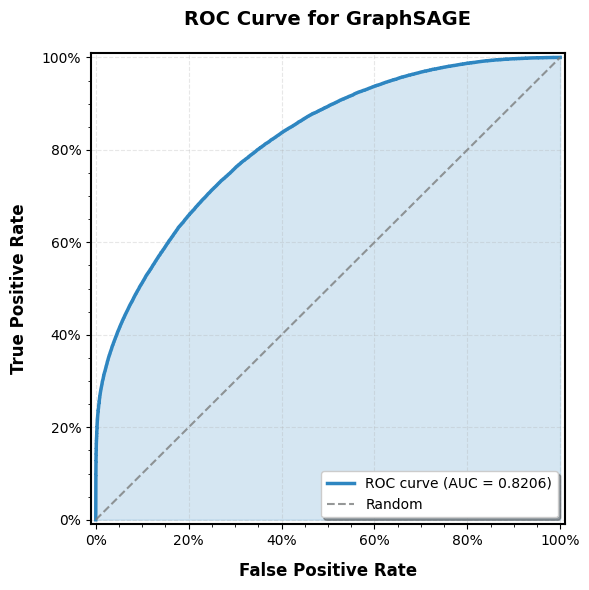

In [ ]:
plot_roc("GraphSAGE")

In [ ]:
pred

array([0.38846773, 0.58382446, 0.935412  , ..., 0.23644865, 0.5492825 ,
       0.01554803], dtype=float32)

In [ ]:
# Пресметување на средна грешка

mean_err = 0
for (p1, t1) in zip(pred, ground_truth):
  mean_err += abs(round(p1)-t1)

mean_err/=len(pred)
mean_err


In [ ]:
from sklearn.metrics import root_mean_squared_error

#Пресметување на RMSE
rmse_sage = root_mean_squared_error(ground_truth, pred)
rmse_sage

0.3953265

In [ ]:
len(pred)

149055

In [ ]:
# Ги ставаме во пар предвидувањето и вистинската вредност
combined = zip(pred, ground_truth)

# Истите ги сортираме според вредноста во предвидувањето во опаѓачки редослед
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)

count = 0

# За кои вредности на k ќе сметаме hit@k
hits = [20, 5000, 10000, 50000]

result_sage_3 = {}
for hit in hits:
  count = 0
  for u,v in sorted_combined[:hit]:
    # Ако вредноста што ја предвидува системот е поголема од 0.5, а реброто навистина постои, тогаш тоа се смета за точно предвидено
    if u > 0.5 and v == 1:
      count += 1
    # Бројот на погодени парови, поделено со k ни дава со колкава прецизност сме ги погодиле првите k предвидувања
    result_sage_3[f"hit@{hit}"] = count / hit

result_sage_3

{'hit@20': 1.0, 'hit@5000': 0.9942, 'hit@10000': 0.9748, 'hit@50000': 0.58712}

In [ ]:
result_sage_3

{'hit@20': 1.0, 'hit@5000': 0.9942, 'hit@10000': 0.9748, 'hit@50000': 0.58712}

##TransformerGNN


In [ ]:
from torch_geometric.nn import TransformerConv, to_hetero
import torch.nn.functional as F
from torch import Tensor
from torch_geometric.data import HeteroData
import torch

# Потполно исто со GraphSAGE, само различна почетна архитектура и различни слоеви се иницијализираат
class TransformerGNN_3(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()

        self.conv1 = TransformerConv(hidden_channels, hidden_channels)
        self.conv2 = TransformerConv(hidden_channels, out_channels)

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_book: Tensor, edge_label_index: Tensor) -> Tensor:


        edge_feat_user = x_user[edge_label_index[0]].to(dtype=x_book.dtype)
        edge_feat_book = x_book[edge_label_index[1]]


        return (edge_feat_user * edge_feat_book).sum(dim=-1)

class TransformerModel_3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()

        self.user_emb = torch.nn.Embedding(data_3["user"].num_nodes, hidden_channels)
        self.book_emb = torch.nn.Embedding(data_3["book"].num_nodes, hidden_channels)


        self.gnn = TransformerGNN_3(hidden_channels, hidden_channels)
        self.gnn = to_hetero(self.gnn, data_3.metadata())
        self.classifier = Classifier()

    def forward(self, data: HeteroData) -> Tensor:

        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "book": self.book_emb(data["book"].node_id),
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)

        pred = self.classifier(
            x_dict["user"],
            x_dict["book"],
            data["user", "review", "book"].edge_label_index,
        )
        return pred

In [ ]:
# Повторно креирање на нов итератор за новиот модел што ќе го тренираме
edge_label_index_3 = train_data_3[target_edge].edge_label_index
edge_label_3 = train_data_3[target_edge].edge_label

train_loader_3 = LinkNeighborLoader(
    data=train_data_3,
    num_neighbors=[50,10],
    neg_sampling_ratio=2.0,
    edge_label_index=(target_edge, edge_label_index_3),
    edge_label=edge_label_3,
    batch_size=500,
    shuffle=True,
)


In [ ]:
# Префрлање на целиот HeteroData објект во GPU за да се искористи можноста за паралелизирање на трансформерите

data_3["user"].node_id = data_3["user"].node_id.to(device)
data_3["book"].node_id = data_3["book"].node_id.to(device)

data_3["book"].x = data_3["book"].x.to(device)

data_3["user","review","book"].edge_index = data_3["user","review","book"].edge_index.to(device)
data_3["book","rev_review","user"].edge_index = data_3["book","rev_review","user"].edge_index.to(device)

In [ ]:
transformerModel_3 = TransformerModel_3(hidden_channels=64)

print(transformerModel_3)

TransformerModel_3(
  (user_emb): Embedding(24685, 64)
  (book_emb): Embedding(11585, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__book): TransformerConv(64, 64, heads=1)
      (book__rev_review__user): TransformerConv(64, 64, heads=1)
    )
    (conv2): ModuleDict(
      (user__review__book): TransformerConv(64, 64, heads=1)
      (book__rev_review__user): TransformerConv(64, 64, heads=1)
    )
  )
  (classifier): Classifier()
)


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F
print(f"Device: '{device}'")

transformerModel_3 = transformerModel_3.to(device)

optimizer = torch.optim.Adam(transformerModel_3.parameters(), lr=0.0001)

# Потполно исто како тренирањето за GraphSAGE
loss_fn = torch.nn.BCELoss()

for epoch in range(1, 10):
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader_3):
        optimizer.zero_grad()

        sampled_data.to(device)

        pred = transformerModel_3(sampled_data)
        pred = torch.nn.Sigmoid()(pred)
        ground_truth = sampled_data[target_edge].edge_label
        loss = loss_fn(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 239/239 [00:08<00:00, 27.02it/s]


Epoch: 001, Loss: 0.6196


100%|██████████| 239/239 [00:10<00:00, 22.33it/s]


Epoch: 002, Loss: 0.5332


100%|██████████| 239/239 [00:10<00:00, 23.37it/s]


Epoch: 003, Loss: 0.4802


100%|██████████| 239/239 [00:08<00:00, 27.15it/s]


Epoch: 004, Loss: 0.4469


100%|██████████| 239/239 [00:10<00:00, 22.24it/s]


Epoch: 005, Loss: 0.4241


100%|██████████| 239/239 [00:10<00:00, 23.77it/s]


Epoch: 006, Loss: 0.4075


100%|██████████| 239/239 [00:09<00:00, 26.53it/s]


Epoch: 007, Loss: 0.3931


100%|██████████| 239/239 [00:10<00:00, 22.06it/s]


Epoch: 008, Loss: 0.3820


100%|██████████| 239/239 [00:09<00:00, 24.10it/s]

Epoch: 009, Loss: 0.3728


In [ ]:
from sklearn.metrics import roc_auc_score

preds = []
ground_truths = []
edges = []
for sampled_data in tqdm(val_loader):
    with torch.no_grad():
        edges.append(sampled_data.edge_index_dict[target_edge])
        sampled_data.to(device)
        out = transformerModel_3(sampled_data)
        p = torch.sigmoid(transformerModel_3(sampled_data))
        preds.append(p)
        ground_truths.append(sampled_data[target_edge].edge_label)

100%|██████████| 299/299 [00:04<00:00, 68.94it/s]


In [ ]:
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.8587


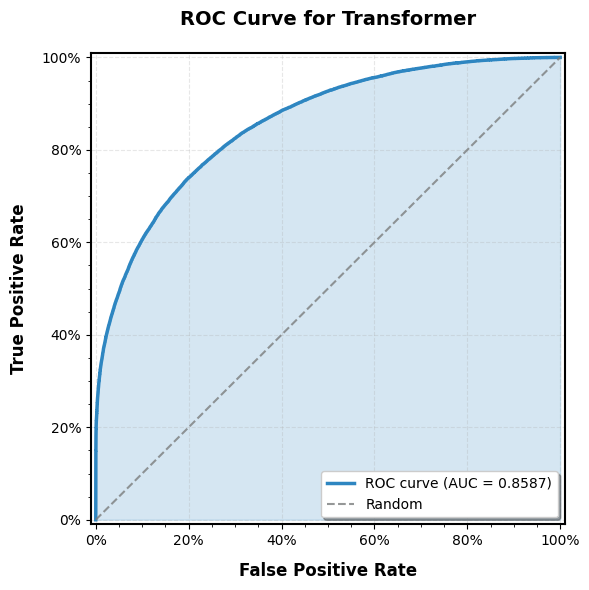

In [ ]:
plot_roc("Transformer")

In [ ]:
pred

array([3.00911665e-01, 1.92950517e-01, 9.81401265e-01, ...,
       1.03985064e-01, 3.71861607e-02, 7.04581616e-05], dtype=float32)

In [ ]:
mean_err = 0
for (p1, t1) in zip(pred, ground_truth):
  mean_err += abs(round(p1)-t1)

mean_err/=len(pred)


In [ ]:
mean_err

0.21302203884472173

In [ ]:
from sklearn.metrics import root_mean_squared_error

rmse_transformer = root_mean_squared_error(ground_truth, pred)
rmse_transformer

0.37903515

In [ ]:
combined = zip(pred, ground_truth)
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
count = 0
hits = [20, 5000, 10000, 50000]
result_transformer_3 = {}
for hit in hits:
  count = 0
  for u,v in sorted_combined[:hit]:
    if u > 0.5 and v == 1:
      count += 1
    result_transformer_3[f"hit@{hit}"] = count / hit

result_transformer_3

{'hit@20': 1.0, 'hit@5000': 0.9992, 'hit@10000': 0.9924, 'hit@50000': 0.68664}

In [ ]:
result_transformer_3

{'hit@20': 1.0, 'hit@5000': 0.9992, 'hit@10000': 0.9924, 'hit@50000': 0.68664}

##Graph Attention Network


In [ ]:
from torch_geometric.nn import GATConv

class GAT_3(torch.nn.Module):
    def __init__(self, hidden_channels, out_channels):
        super().__init__()
        # Првиот слој во мрежата, влезната и излезната големина се дознава од податоците.
        # Self Loops не постојат затоа што имаме бипартитен граф
        self.conv1 = GATConv((-1,-1), hidden_channels,add_self_loops = False)
        # Вториот слој има влез според бројот на скриени канали, а излез зададен од корисникот
        self.conv2 = GATConv(hidden_channels,out_channels, add_self_loops = False)

    def forward(self, x, edge_index):

        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index)
        return x


class Classifier(torch.nn.Module):
    def forward(self, x_user: Tensor, x_book: Tensor, edge_label_index: Tensor) -> Tensor:

        edge_feat_user = x_user[edge_label_index[0]].to(dtype=x_book.dtype)
        edge_feat_book = x_book[edge_label_index[1]]

        return (edge_feat_user * edge_feat_book).sum(dim=-1)



class GATModel_3(torch.nn.Module):
    def __init__(self, hidden_channels):
        super().__init__()
        self.user_emb = torch.nn.Embedding(data_3["user"].num_nodes, hidden_channels)
        self.book_emb = torch.nn.Embedding(data_3["book"].num_nodes, hidden_channels)

        self.gnn = GAT_3(hidden_channels, hidden_channels)
        self.gnn = to_hetero(self.gnn, data_3.metadata())
        self.classifier = Classifier()

    def forward(self, data):
        x_dict = {
          "user": self.user_emb(data["user"].node_id),
          "book": self.book_emb(data["book"].node_id),
        }

        x_dict = self.gnn(x_dict, data.edge_index_dict)


        pred = self.classifier(
            x_dict["user"],
            x_dict["book"],
            data["user", "review", "book"].edge_label_index,
        )

        return pred


In [ ]:
gatModel_3 = GATModel_3(hidden_channels=64).to(device)

print(gatModel_3)

GATModel_3(
  (user_emb): Embedding(24685, 64)
  (book_emb): Embedding(11585, 64)
  (gnn): GraphModule(
    (conv1): ModuleDict(
      (user__review__book): GATConv((-1, -1), 64, heads=1)
      (book__rev_review__user): GATConv((-1, -1), 64, heads=1)
    )
    (conv2): ModuleDict(
      (user__review__book): GATConv(64, 64, heads=1)
      (book__rev_review__user): GATConv(64, 64, heads=1)
    )
  )
  (classifier): Classifier()
)


In [ ]:
from tqdm import tqdm
import torch.nn.functional as F


optimizer = torch.optim.Adam(gatModel_3.parameters(), lr=0.01)

print(f"Device: '{device}'")

# Исто како и другите модели
loss_fn = torch.nn.BCELoss()

for epoch in range(1, 6):
    total_loss = total_examples = 0
    for sampled_data in tqdm(train_loader_3):
        optimizer.zero_grad()

        sampled_data.to(device)

        pred = gatModel_3(sampled_data)
        pred = torch.nn.Sigmoid()(pred)
        ground_truth = sampled_data[target_edge].edge_label
        loss = loss_fn(pred, ground_truth)

        loss.backward()
        optimizer.step()
        total_loss += float(loss) * pred.numel()
        total_examples += pred.numel()
    print(f"Epoch: {epoch:03d}, Loss: {total_loss / total_examples:.4f}")

Device: 'cuda'


100%|██████████| 239/239 [00:10<00:00, 22.36it/s]


Epoch: 001, Loss: 0.4419


100%|██████████| 239/239 [00:09<00:00, 24.46it/s]


Epoch: 002, Loss: 0.3408


100%|██████████| 239/239 [00:06<00:00, 34.38it/s]


Epoch: 003, Loss: 0.3088


100%|██████████| 239/239 [00:10<00:00, 23.81it/s]


Epoch: 004, Loss: 0.2905


100%|██████████| 239/239 [00:10<00:00, 22.78it/s]

Epoch: 005, Loss: 0.2763


In [ ]:
# Зачувување на моделот за користење во Flask
torch.save({
    'model_state_dict': gatModel_3.state_dict(),
    'optimizer_state_dict': optimizer.state_dict()
}, 'gat_model_3.pth')

In [ ]:
edge_label_index_3 = val_data_3[target_edge].edge_label_index
edge_label_3 = val_data_3[target_edge].edge_label

val_loader = LinkNeighborLoader(
    data=val_data_3,
    num_neighbors=[20, 5],
    edge_label_index=(target_edge, edge_label_index_3),
    edge_label=edge_label_3,
    batch_size=500,
    shuffle=False,
)

In [ ]:
from sklearn.metrics import roc_auc_score, roc_curve

preds = []
ground_truths = []
edges = []
for sampled_data in tqdm(val_loader):
    with torch.no_grad():
        edges.append(sampled_data.edge_index_dict[target_edge])
        sampled_data.to(device)
        out = gatModel_3(sampled_data)
        p = torch.sigmoid(gatModel_3(sampled_data))
        preds.append(p)
        ground_truths.append(sampled_data[target_edge].edge_label)

100%|██████████| 299/299 [00:04<00:00, 66.74it/s]


In [ ]:
pred = torch.cat(preds, dim=0).cpu().numpy()
ground_truth = torch.cat(ground_truths, dim=0).cpu().numpy()
auc = roc_auc_score(ground_truth, pred)
print()
print(f"Validation AUC: {auc:.4f}")


Validation AUC: 0.9149


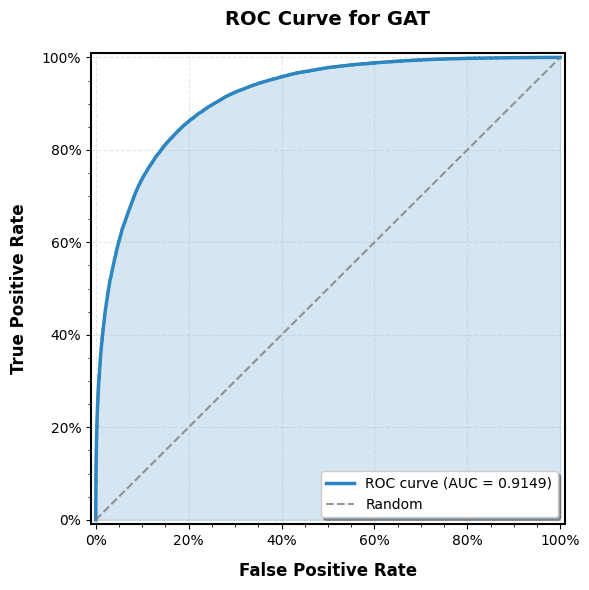

In [ ]:
plot_roc("GAT")

In [ ]:
pred

array([8.1564111e-01, 2.9710260e-01, 7.8164959e-01, ..., 7.9936141e-01,
       1.3657240e-07, 3.8360609e-03], dtype=float32)

In [ ]:
mean_err = 0
for (p1, t1) in zip(pred, ground_truth):
  mean_err += abs(round(p1)-t1)

mean_err/=len(pred)


In [ ]:
mean_err

0.15458723290060716

In [ ]:
from sklearn.metrics import root_mean_squared_error

rmse_GAT = root_mean_squared_error(ground_truth, pred)
rmse_GAT

0.33332652

In [ ]:
combined = zip(pred, ground_truth)
sorted_combined = sorted(combined, key=lambda x: x[0], reverse=True)
count = 0
hits = [20, 5000, 10000, 50000]
result_gat_3 = {}
for hit in hits:
  count = 0
  for u,v in sorted_combined[:hit]:
    if u > 0.5 and v == 1:
      count += 1

    result_gat_3[f"hit@{hit}"] = count / hit

result_gat_3

{'hit@20': 1.0, 'hit@5000': 0.9886, 'hit@10000': 0.9774, 'hit@50000': 0.7023}

In [ ]:
result_gat_3

{'hit@20': 1.0, 'hit@5000': 0.9886, 'hit@10000': 0.9774, 'hit@50000': 0.7023}

#Evaluation


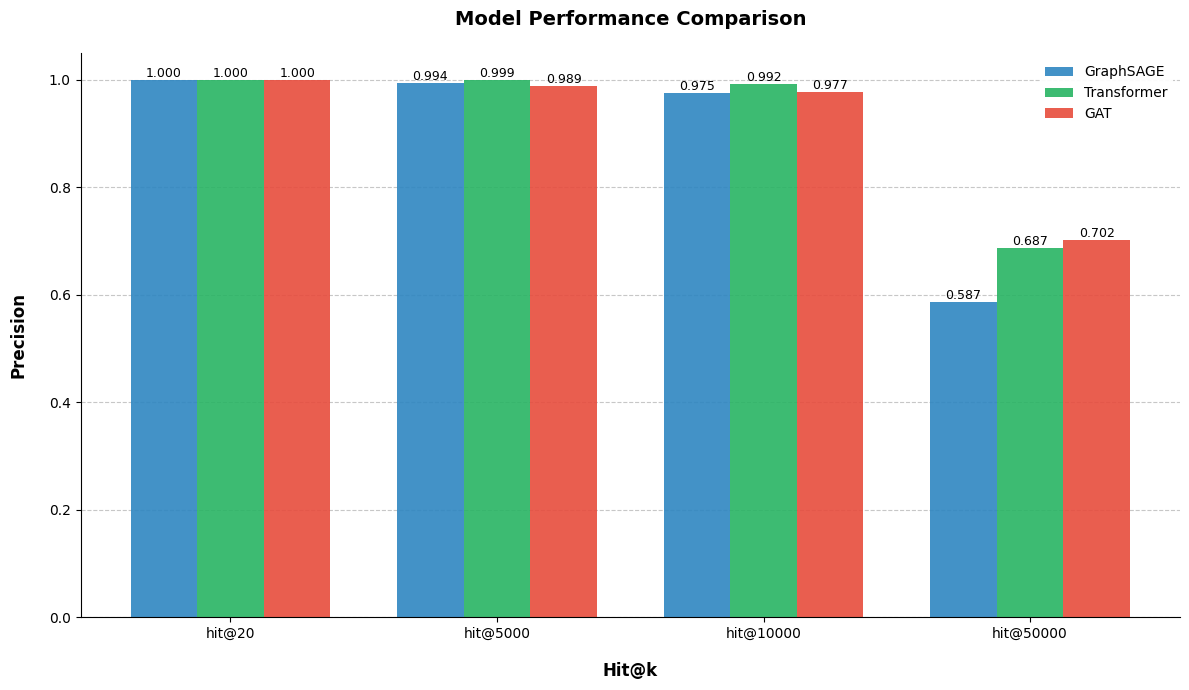

In [ ]:
# Ги земаме вредностите и ги поставуваме во посебни променливи
x_labels = list(result_sage_3.keys())
model1_values = list(result_sage_3.values())
model2_values = list(result_transformer_3.values())
model3_values = list(result_gat_3.values())

# Ширина и локација на столбови
bar_width = 0.25
r1 = np.arange(len(model1_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]


colors = ['#2E86C1', '#28B463', '#E74C3C']


fig, ax = plt.subplots(figsize=(12, 7))

# Цртање на графикот
bars1 = ax.bar(r1, model1_values, color=colors[0], width=bar_width, label='GraphSAGE', alpha=0.9)
bars2 = ax.bar(r2, model2_values, color=colors[1], width=bar_width, label='Transformer', alpha=0.9)
bars3 = ax.bar(r3, model3_values, color=colors[2], width=bar_width, label='GAT', alpha=0.9)

# Прилагодување на текстот
ax.set_xlabel('Hit@k', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Precision', fontsize=12, fontweight='bold', labelpad=15)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)

# Позиционирање на лабелите на х оската
ax.set_xticks([r + bar_width for r in range(len(model1_values))])
ax.set_xticklabels(x_labels, fontsize=10)

# Поставки за grid
ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)

# Поставување текст над столбовите
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)


ax.legend(loc='upper right', frameon=True, framealpha=0.95,
         edgecolor='none', fontsize=10)


plt.tight_layout()

# Отстранување на горната и десната надворешна линија на графикот
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.show()

149055
[20, 5000, 10000, 50000]
{'hit@20': 0.5, 'hit@5000': 0.4908, 'hit@10000': 0.4869, 'hit@50000': 0.49998}


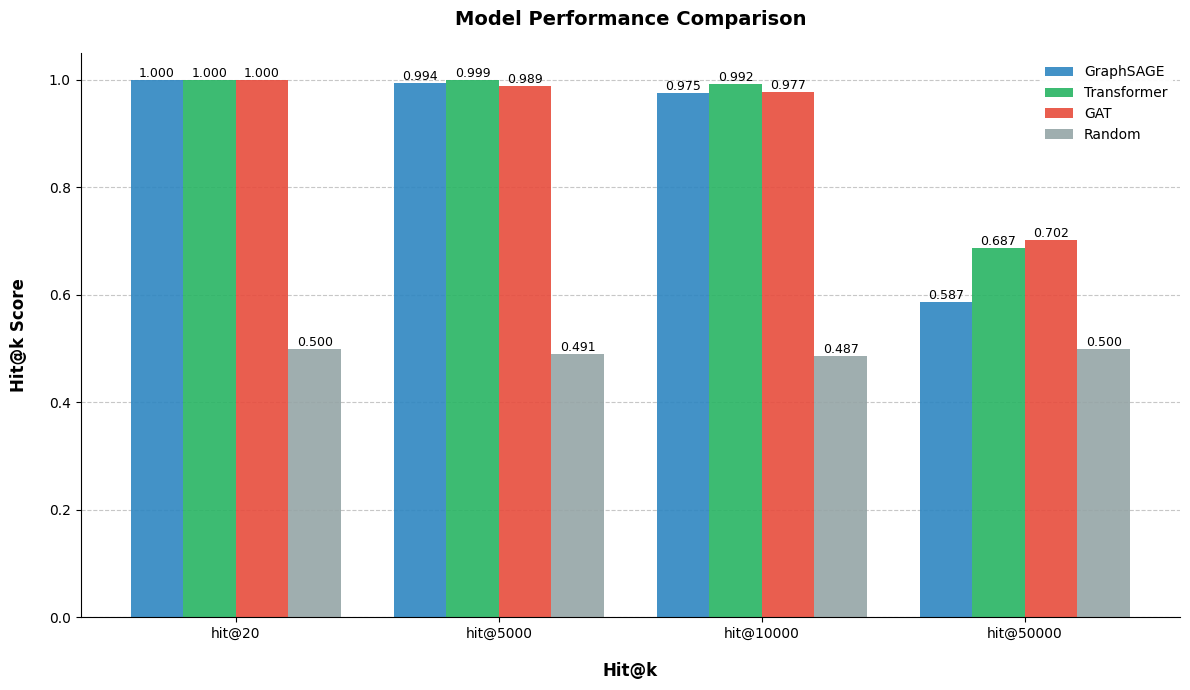

In [ ]:
#Следно ќе генерираме случаен модел и ќе го споредиме со нашите модели

# Превземање на k вредности
k_values = [int(label.split('@')[1]) for label in x_labels]

print(k_values)
random_values = {}

rng = np.random.default_rng()

for k in k_values:
  hit = 0
  # k_grounds = ground_truth.choose(k)
  k_grounds = rng.choice(ground_truth,k)
  for i in range(k):
    # Пробуваме случајно да ги погодиме првите K елементи
    if(k_grounds[i] == random.randint(0,1)):
      hit+=1
  random_values[f"hit@{k}"] = hit/k

print(random_values)

# Од овде, исто како претходниот график
x_labels = list(result_sage_3.keys())
model1_values = list(result_sage_3.values())
model2_values = list(result_transformer_3.values())
model3_values = list(result_gat_3.values())
model4_values = list(random_values.values())

# Малку помал столб бидејќи сега има уште еден (случајниот модел)
bar_width = 0.2
r1 = np.arange(len(model1_values))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]


colors = ['#2E86C1', '#28B463', '#E74C3C', '#95A5A6']


fig, ax = plt.subplots(figsize=(12, 7))


bars1 = ax.bar(r1, model1_values, color=colors[0], width=bar_width, label='GraphSAGE', alpha=0.9)
bars2 = ax.bar(r2, model2_values, color=colors[1], width=bar_width, label='Transformer', alpha=0.9)
bars3 = ax.bar(r3, model3_values, color=colors[2], width=bar_width, label='GAT', alpha=0.9)
bars4 = ax.bar(r4, model4_values, color=colors[3], width=bar_width, label='Random', alpha=0.9)


ax.set_xlabel('Hit@k', fontsize=12, fontweight='bold', labelpad=15)
ax.set_ylabel('Hit@k Score', fontsize=12, fontweight='bold', labelpad=15)
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold', pad=20)


ax.set_xticks([r + 1.5 * bar_width for r in range(len(model1_values))])
ax.set_xticklabels(x_labels, fontsize=10)


ax.grid(True, axis='y', linestyle='--', alpha=0.7)
ax.set_axisbelow(True)


def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=9)

add_value_labels(bars1)
add_value_labels(bars2)
add_value_labels(bars3)
add_value_labels(bars4)

ax.legend(loc='upper right', frameon=True, framealpha=0.95,
         edgecolor='none', fontsize=10)

plt.tight_layout()

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)


plt.show()

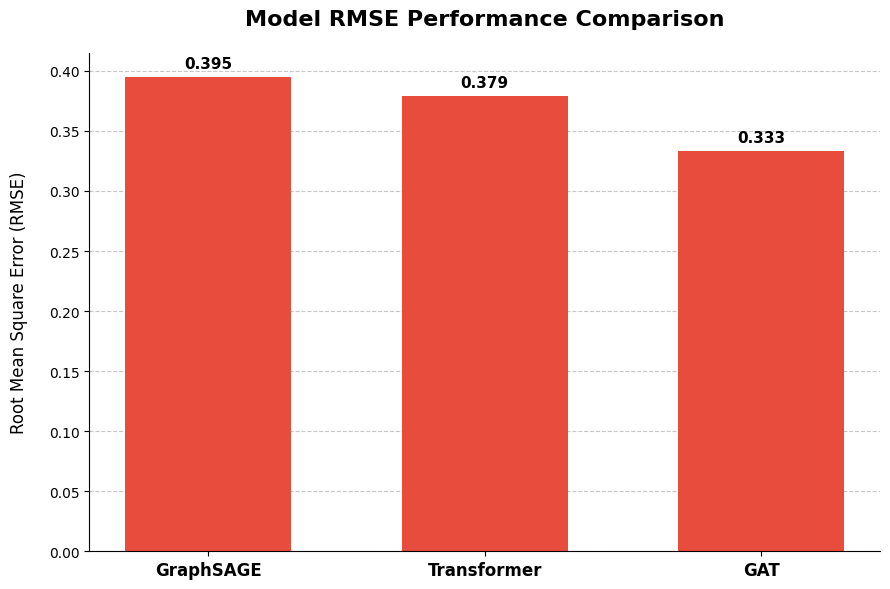

In [ ]:
# Ќе направиме и споредба меѓу RMSE вредностите

models = ['GraphSAGE', 'Transformer', 'GAT']
rmse_scores = [rmse_sage, rmse_transformer, rmse_GAT]


fig, ax = plt.subplots(figsize=(9, 6))


color = ['#E74C3C']

bar_width = 0.6
x_pos = np.arange(len(models))  # Креирање на позициите за столбовите
bars = ax.bar(x_pos, rmse_scores, width=bar_width, color = color)


ax.set_title('Model RMSE Performance Comparison', pad=20, fontsize=16, fontweight='bold')
ax.set_ylabel('Root Mean Square Error (RMSE)', fontsize=12, labelpad=15)


ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.3f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')


ax.yaxis.grid(True, linestyle='--', alpha=0.7)
ax.set_axisbelow(True)


ax.set_xticks(x_pos)
ax.set_xticklabels(models, fontsize=12, fontweight='bold')

fig.patch.set_facecolor('white')

plt.tight_layout()

plt.show()



---



# Saving data for Flask:

In [ ]:
original_books.head(2)

Title  \
0                     Its Only Art If Its Well Hung!   
1                           Dr. Seuss: American Icon   
2              Wonderful Worship in Smaller Churches   
3                      Whispers of the Wicked Saints   
4  Nation Dance: Religion, Identity and Cultural ...   

                                         description              authors  \
0                                                NaN     ['Julie Strain']   
1  Philip Nel takes a fascinating look into the k...       ['Philip Nel']   
2  This resource includes twelve principles in un...     ['David R. Ray']   
3  Julia Thomas finds her life spinning out of co...  ['Veronica Haddon']   
4                                                NaN      ['Edward Long']   

                                               image  \
0  http://books.google.com/books/content?id=DykPA...   
1  http://books.google.com/books/content?id=IjvHQ...   
2  http://books.google.com/books/content?id=2tsDA...   
3  http://books.google.com/books/content?id=aRSIg...   
4                                                NaN   

                                         previewLink  publisher publishedDate  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...        NaN          1996   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&p...  A&C Black    2005-01-01   
2  http://books.google.nl/books?id=2tsDAAAACAAJ&d...        NaN          2000   
3  http://books.google.nl/books?id=aRSIgJlq6JwC&d...  iUniverse       2005-02   
4  http://books.google.nl/books?id=399SPgAACAAJ&d...        NaN    2003-03-01   

                                            infoLink  \
0  http://books.google.nl/books?id=DykPAAAACAAJ&d...   
1  http://books.google.nl/books?id=IjvHQsCn_pgC&d...   
2  http://books.google.nl/books?id=2tsDAAAACAAJ&d...   
3  http://books.google.nl/books?id=aRSIgJlq6JwC&d...   
4  http://books.google.nl/books?id=399SPgAACAAJ&d...   

                      categories  ratingsCount  
0    ['Comics & Graphic Novels']           NaN  
1  ['Biography & Autobiography']           NaN  
2                   ['Religion']           NaN  
3                    ['Fiction']           NaN  
4                            NaN           NaN

In [ ]:
books_filtered.columns

Index(['Id', 'Title', 'User_id', 'review/score', 'review/time',
       'review/summary', 'review/text', 'description', 'authors', 'image',
       'publisher', 'publishedDate', 'categories', 'book_node_id',
       'user_node_id'],
      dtype='object')

In [ ]:
books_filtered.head(2)

Id             Title         User_id  review/score  review/time  \
3  B000N7612G  The Food Of Love  A2V6FC7GVZ6T7M           5.0   1285459200   
4  B000N7612G  The Food Of Love  A1ZMXRS5770YKG           4.0   1269648000   
5  B000N7612G  The Food Of Love  A2XY7UO3HTBFLF           5.0   1151712000   
6  B000N7612G  The Food Of Love   AKPQSBU4BZNZY           4.0   1111622400   
7  B000N7612G  The Food Of Love  A1HS3BUBNZJJD6           5.0   1096848000   

                     review/summary  \
3                  The Food of Love   
4                  A Taste of Italy   
5                  simply delicious   
6                        Cameriere!   
7  Delicioso; virtuoso; bellissimo!   

                                         review/text  \
3  A tale of tangled relationships and excellent ...   
4  Longing for vicarious travel? Imagining your c...   
5  This is a very sensual book, bringing to life ...   
6  I enjoyed this book-- it was much better than ...   
7  Food, especially Italian food, and love. Just ...   

                                         description          authors  \
3  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
4  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
5  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
6  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   
7  Een heerlijke roman over culinaire verleiding ...  Anthony Capella   

                                               image publisher publishedDate  \
3  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
4  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
5  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
6  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   
7  http://books.google.com/books/content?id=pyFZA...  Boekerij    2013-12-17   

  categories  book_node_id  user_node_id  
3    Fiction             0             0  
4    Fiction             0             1  
5    Fiction             0             2  
6    Fiction             0             3  
7    Fiction             0             4

In [ ]:
# Со ова ги добиваме сите информации кои претходно ги избришавме за филтрираните книги
b_merged = pd.merge(original_books, books_filtered, how="inner", on="Title")

In [ ]:
b_merged

Title  \
0                                        The Food Of Love   
1                                        The Food Of Love   
2                                        The Food Of Love   
3                                        The Food Of Love   
4                                        The Food Of Love   
...                                                   ...   
496852  The social contract,: And Discourses (Everyman...   
496853  The social contract,: And Discourses (Everyman...   
496854  The social contract,: And Discourses (Everyman...   
496855  The social contract,: And Discourses (Everyman...   
496856  The social contract,: And Discourses (Everyman...   

                                            description_x  \
0       Een heerlijke roman over culinaire verleiding ...   
1       Een heerlijke roman over culinaire verleiding ...   
2       Een heerlijke roman over culinaire verleiding ...   
3       Een heerlijke roman over culinaire verleiding ...   
4       Een heerlijke roman over culinaire verleiding ...   
...                                                   ...   
496852                                                NaN   
496853                                                NaN   
496854                                                NaN   
496855                                                NaN   
496856                                                NaN   

                  authors_x  \
0       ['Anthony Capella']   
1       ['Anthony Capella']   
2       ['Anthony Capella']   
3       ['Anthony Capella']   
4       ['Anthony Capella']   
...                     ...   
496852                  NaN   
496853                  NaN   
496854                  NaN   
496855                  NaN   
496856                  NaN   

                                                  image_x  \
0       http://books.google.com/books/content?id=pyFZA...   
1       http://books.google.com/books/content?id=pyFZA...   
2       http://books.google.com/books/content?id=pyFZA...   
3       http://books.google.com/books/content?id=pyFZA...   
4       http://books.google.com/books/content?id=pyFZA...   
...                                                   ...   
496852                                                NaN   
496853                                                NaN   
496854                                                NaN   
496855                                                NaN   
496856                                                NaN   

                                              previewLink publisher_x  \
0       http://books.google.nl/books?id=pyFZAgAAQBAJ&p...    Boekerij   
1       http://books.google.nl/books?id=pyFZAgAAQBAJ&p...    Boekerij   
2       http://books.google.nl/books?id=pyFZAgAAQBAJ&p...    Boekerij   
3       http://books.google.nl/books?id=pyFZAgAAQBAJ&p...    Boekerij   
4       http://books.google.nl/books?id=pyFZAgAAQBAJ&p...    Boekerij   
...                                                   ...         ...   
496852                                                NaN         NaN   
496853                                                NaN         NaN   
496854                                                NaN         NaN   
496855                                                NaN         NaN   
496856                                                NaN         NaN   

       publishedDate_x                                           infoLink  \
0           2013-12-17  http://books.google.nl/books?id=pyFZAgAAQBAJ&d...   
1           2013-12-17  http://books.google.nl/books?id=pyFZAgAAQBAJ&d...   
2           2013-12-17  http://books.google.nl/books?id=pyFZAgAAQBAJ&d...   
3           2013-12-17  http://books.google.nl/books?id=pyFZAgAAQBAJ&d...   
4           2013-12-17  http://books.google.nl/books?id=pyFZAgAAQBAJ&d...   
...                ...                                                ...   
496852             NaN                                          

In [ ]:
# Со ова пресметуваме колку рецензии имаме за дадена книга во множеството и го поставуваме тој број во #reviews колоната
b_merged = pd.merge(b_merged, b_merged.groupby(["Title"])["Title"].count().rename("#reviews").to_frame(),how="inner" , on="Title")

In [ ]:

b_merged.groupby(["Title"])["review/score"].mean().rename("Average Score").to_frame()

Average Score
Title                                                            
"A" IS FOR ALIBI                                         3.957143
"C" is for Corpse (A Kinsey Millhone mystery, B...       4.216216
"D" is for Deadbeat                                      4.379310
"F" is for fugitive: A Kinsey Millhone mystery           4.464286
"I, the Jury"                                            4.235294
...                                                           ...
the illustrated man                                      4.476190
the rebels                                               4.583333
the story of ferdinand                                   4.888889
ttyl                                                     4.142857
using what you got                                       4.100000

[11585 rows x 1 columns]

In [ ]:
# Пресметуваме средна оценка според дадените рецензии во нашите филтрирани податоци
b_merged = pd.merge(b_merged, b_merged.groupby(["Title"])["review/score"].mean().rename("Average Score").to_frame(),how="inner" , on="Title")

In [ ]:
b_merged = b_merged.drop_duplicates("Title")

In [ ]:
b_merged.columns

Index(['Title', 'description_x', 'authors_x', 'image_x', 'previewLink',
       'publisher_x', 'publishedDate_x', 'infoLink', 'categories_x',
       'ratingsCount', 'Id', 'User_id', 'review/score', 'review/time',
       'review/summary', 'review/text', 'description_y', 'authors_y',
       'image_y', 'publisher_y', 'publishedDate_y', 'categories_y',
       'book_node_id', 'user_node_id', '#reviews', 'Average Score'],
      dtype='object')

In [ ]:
b_merged = b_merged[['Title', 'description_x', 'authors_x', 'image_x', 'previewLink',
       'publisher_x', 'publishedDate_x', 'infoLink', 'categories_x',
       'ratingsCount', "book_node_id", "#reviews", "Average Score"]]

In [ ]:
b_merged = b_merged.reset_index()

In [ ]:
b_merged.to_csv("books.csv")

In [ ]:
b_merged = b_merged.drop_duplicates("Title")


In [ ]:
b_merged

index                                              Title  \
0           0                                   The Food Of Love   
1          11                   The Scarletti Curse (Candleglow)   
2          28  Cruel and Unusual (G K Hall Large Print Book S...   
3          59                                    The Rabbi's Cat   
4          68                                From Potter's Field   
...       ...                                                ...   
11580  496765                                      The Songlines   
11581  496785  Mount Vernon Love Story: A Novel of George and...   
11582  496799    Heart of the World (Carlotta Carlyle Mysteries)   
11583  496809  The Exception to the Rulers : Exposing Oily Po...   
11584  496833  The social contract,: And Discourses (Everyman...   

                                           description_x  \
0      Een heerlijke roman over culinaire verleiding ...   
1                                                    NaN   
2      Wanneer er in dit achtste deel in de Kay Scarp...   
3      Gaining the ability to speak after swallowing ...   
4      The sixth book in the Kay Scarpetta series, fr...   
...                                                  ...   
11580                                                NaN   
11581  Always a lover of history, Mary Higgins Clark ...   
11582  The Boston PI tangles with the Colombian under...   
11583                                                NaN   
11584                                                NaN   

                    authors_x  \
0         ['Anthony Capella']   
1        ['Christine Feehan']   
2       ['Patricia Cornwell']   
3              ['Joann Sfar']   
4       ['Patricia Cornwell']   
...                       ...   
11580                     NaN   
11581  ['Mary Higgins Clark']   
11582        ['Linda Barnes']   
11583                     NaN   
11584                     NaN   

                                                 image_x  \
0      http://books.google.com/books/content?id=pyFZA...   
1                                                    NaN   
2      http://books.google.com/books/content?id=AgckD...   
3      http://books.google.com/books/content?id=cNQbA...   
4      http://books.google.com/books/content?id=prefg...   
...                                                  ...   
11580                                                NaN   
11581  http://books.google.com/books/content?id=4iHwp...   
11582  http://books.google.com/books/content?id=79qCD...   
11583                                                NaN   
11584                                                NaN   

                                             previewLink         publisher_x  \
0      http://books.google.nl/books?id=pyFZAgAAQBAJ&p...            Boekerij   
1      http://books.google.nl/books?id=2YXLtAEACAAJ&d...                 NaN   
2      http://books.google.nl/books?id=AgckDwAAQBAJ&p...   Luitingh Sijthoff   
3      http://books.google.nl/books?id=cNQbAQAAIAAJ&q...            Pantheon   
4      http://books.google.nl/books?id=prefgSxnGOwC&p...         Hachette UK   
...                                                  ...                 ...   
11580                                                NaN                 NaN   
11581  http://books.google.com/books?id=4iHwpTx1M84C&...  Simon and Schuster   
11582  http://books.google.com/books?id=79qCDwAAQBAJ&...     Open Road Media   
11583                                                NaN                 NaN   
11584                                                NaN                 NaN   

      publishedDate_x                                           infoLink  \
0          2013-12-17  http://books.google.nl/books?id=pyFZAgAAQBAJ&d...   
1                 NaN  http://books.google.nl/books?id=2YXLtAEACAAJ&d...   
2          2017-06-01  https://play.google.com/store/books/details?id...   
3                2005  http://books.google.nl/books?id=cNQbAQAAIAAJ&d...   
4          

In [ ]:
books_filtered.to_csv("books.csv")
